In [759]:

def calcular_epsilon(u):
    
    import numpy as np
    import ufl

    # Tensor de identidad
    I = ufl.Identity(2)
    # Tensor de deformación
    F = I + ufl.grad(u)
    # Tensor de deformación derecho o tensor de Cauchy-Green
    C = ufl.variable(F.T * F)
    
    # Tolerancia
    #tol = DOLFIN_EPS
    tol=0.000000001
    # Determinar perturbación a partir de la tolerancia
    pert = 2 * tol

    # Obtener invariantes requeridos
    I1 = ufl.tr(C)  # traza del tensor
    I3 = ufl.det(C)  # determinante del tensor

    # Valor preliminar para el discriminante
    D = I1**2 - 4 * I3
    # Agregar perturbación numérica al discriminante si está cerca de cero; asegurar positividad de D
    D = ufl.conditional(ufl.lt(D, tol), abs(D) + pert, D)

    lambda1 = 0.5 * (I1 + ufl.sqrt(D))
    lambda2 = I3 / lambda1

    # Tensor de identidad
    I = ufl.Identity(2)

    # Calcular tensores de proyección individuales
    M1 = (C - lambda2 * I) / (lambda1 - lambda2)
    M2 = (C - lambda1 * I) / (lambda2 - lambda1)

    #lamU1 = sqrt(lambda1)
    #lamU2 = sqrt(lambda2)

    # Calcular tensor de deformación epsilon
    #d = ufl.ln(lamU1) * M1 + ufl.ln(lamU2) * M2
    d = 0.5*ufl.ln(lambda1) * M1 + 0.5*ufl.ln(lambda2) * M2
    epsilon= (d.T+d)*0.5
    return epsilon

def calcular_U(u):
    
    import numpy as np
    import ufl

    # Tensor de identidad
    I = ufl.Identity(2)
    # Tensor de deformación
    F = I + ufl.grad(u)
    # Tensor de deformación derecho o tensor de Cauchy-Green
    C = ufl.variable(F.T * F)
    
    # Tolerancia
    #tol = DOLFIN_EPS
    tol=0.000000001
    # Determinar perturbación a partir de la tolerancia
    pert = 2 * tol

    # Obtener invariantes requeridos
    I1 = ufl.tr(C)  # traza del tensor
    I3 = ufl.det(C)  # determinante del tensor

    # Valor preliminar para el discriminante
    D = I1**2 - 4 * I3
    # Agregar perturbación numérica al discriminante si está cerca de cero; asegurar positividad de D
    D = ufl.conditional(ufl.lt(D, tol), abs(D) + pert, D)

    lambda1 = 0.5 * (I1 + ufl.sqrt(D))
    lambda2 = I3 / lambda1

    # Tensor de identidad
    I = ufl.Identity(2)

    # Calcular tensores de proyección individuales
    M1 = (C - lambda2 * I) / (lambda1 - lambda2)
    M2 = (C - lambda1 * I) / (lambda2 - lambda1)

    lamU1 = ufl.sqrt(lambda1)
    lamU2 =ufl.sqrt(lambda2)

    # Calcular tensor de deformación epsilon
    #d = ufl.ln(lamU1) * M1 + ufl.ln(lamU2) * M2
    U = 0.5*(lamU1) * M1 + 0.5*(lamU1) * M2
   
    return U


In [760]:
import fenics as fe

#Propiedades
E = 1.0e9  # Módulo de Young en Pa
nu = 0.23  # Coeficiente de Poisson

mu = E / (2.0*(1.0 + nu))
lmbda = E*nu / ((1.0 + nu)*(1.0 - 2.0*nu))

# Definir el cuadrado

L = 1  # Longitud del lado del cuadrado
LL=L

Nmesh=10
mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(L, L), Nmesh, Nmesh,diagonal="crossed")

# Definir el espacio de funciones
V = fe.VectorFunctionSpace(mesh, "CG", 2,dim=2)

# Definir condiciones de contorno
def boundary_bottom(x, on_boundary):
    return on_boundary and fe.near(x[1], 0) 



def boundary_top(x, on_boundary):
    return on_boundary and fe.near(x[1], LL)

bc_bottom = fe.DirichletBC(V, fe.Constant((0, 0)), boundary_bottom)
bc_top = fe.DirichletBC(V, fe.Constant((1, 0)), boundary_top)  # Desplazamiento en x = 1 en la parte superior
bcs = [bc_bottom, bc_top]

# Definir problema variacional
u = fe.TrialFunction(V)
v = fe.TestFunction(V)
f = fe.Constant((0, 0))  # Fuerza de corte
T = fe.Constant((0, 0))  # Tensión de corte
I=fe.Identity(2)

eps=fe.sym(fe.grad(u))
stress = fe.variable(lmbda * fe.tr(eps) * I + 2.0 * mu * eps)  # Tensor de esfuerzo 

a = fe.inner(stress, fe.sym(fe.nabla_grad(v))) * fe.dx
#a = fe.inner(fe.grad(u), fe.grad(v)) * fe.dx #gradiente de prueba dinamico

L = fe.dot(f, v) * fe.dx + fe.dot(T, v) * fe.ds

# Resolver el problema
u = fe.Function(V)
fe.solve(a == L, u, bcs)




                                                                                                                                                                Solving linear variational problem.


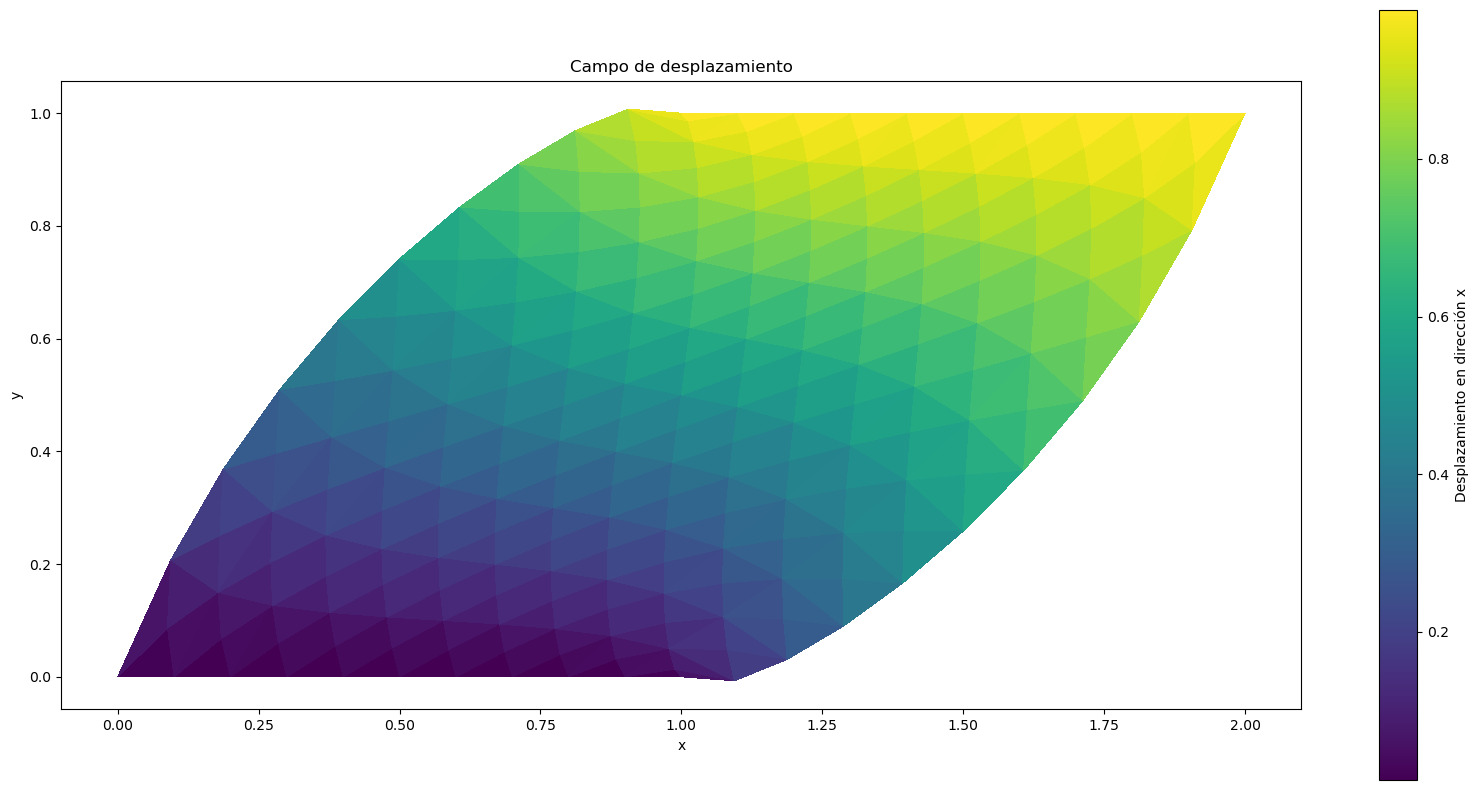

In [761]:
import matplotlib.pyplot as plt


# Plotear el campo de desplazamiento
plt.figure(figsize=(20, 10))
P=fe.plot(u, mode="displacement")
plt.title("Campo de desplazamiento")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(P, label="Desplazamiento en dirección x")
# Mostrar el gráfico
plt.show()

In [843]:
import numpy as np
import fenics as fe
import ufl
#Tipo De aproximacion

#"Green" "Finite" "Henky"
Aprox="Finite"

#"Lineal" "Hyper"
Modelo = "Hyper"

# Definir el cuadrado
L =10 # Longitud del lado del cuadrado
Nmesh=3
mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(L, L),Nmesh,Nmesh ,diagonal="crossed")

# Definir el espacio de funciones
V = fe.VectorFunctionSpace(mesh, "CG", 1,dim=2)

# Definir la variable de rotación (en radianes)
theta = fe.Constant(np.pi/4)

# Definir las expresiones de rotación para cada esquina
rot_topL = fe.Expression(("x[0]*cos(theta)-x[1]*sin(theta)","x[0]*sin(theta)+x[1]*cos(theta)-x[1]"), theta=theta, degree=0)
rot_topR = fe.Expression(("x[0]*cos(theta)-x[1]*sin(theta)-x[0]","x[0]*sin(theta)+x[1]*cos(theta)-x[1]"), theta=theta, degree=0)
rot_botR = fe.Expression(("x[0]*cos(theta)-x[1]*sin(theta)-x[0]","x[0]*sin(theta)+x[1]*cos(theta)"), theta=theta, degree=0)

# Aplicar condiciones de contorno con rotación en cada esquina
corner_fixed = fe.AutoSubDomain(lambda x: np.logical_and(fe.near(x[0], 0.0), fe.near(x[1], 0.0)))
corner_topL = fe.AutoSubDomain(lambda x: np.logical_and(fe.near(x[0], 0.0), fe.near(x[1], L)))
corner_topR = fe.AutoSubDomain(lambda x: np.logical_and(fe.near(x[0], L), fe.near(x[1], L)))
corner_botR = fe.AutoSubDomain(lambda x: np.logical_and(fe.near(x[0], L), fe.near(x[1], 0.0)))

bc_fixed_corner = fe.DirichletBC(V, fe.Constant((0., 0.)), corner_fixed, method='pointwise')  
bc_topL = fe.DirichletBC(V, rot_topL, corner_topL, method='pointwise') 
bc_topR = fe.DirichletBC(V, rot_topR, corner_topR, method='pointwise') 
bc_botR = fe.DirichletBC(V, rot_botR, corner_botR, method='pointwise') 

bcs=([bc_fixed_corner, bc_topL, bc_topR, bc_botR])

# Definir las variables
u = fe.Function(V,name="Displacement")  # Desplazamiento
v = fe.TestFunction(V)  # Función de prueba

f = fe.Constant((0, 0))  # Fuerza de corte
T = fe.Constant((0, 0))  # Tensión de corte

# Definir las propiedades del material hiperelástico
E = 100 # Módulo de Young en Pa
nu = 0.3# Coeficiente de Poisson

mu = E / (2.0 * (1.0 + nu))
lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

I = fe.Identity(2)  # Tensor de identidad
F = I + fe.grad(u)  # Tensor de deformación
C = fe.variable(F.T * F)  # Tensor de deformación derecho o tensor de Cauchy-Green

if Aprox == "Finite":
    if Modelo == "Lineal":
        eps = fe.sym(fe.grad(u))
    elif Modelo=="Hyper":
        #Coordenadas Lagrangianas
        R=calcular_U(u)*fe.inv(F)
        eps = R*fe.sym(fe.grad(u))*R.T
elif Aprox == "Green":
    eps = 0.5 * (C - I)
elif Aprox == "Henky":
    # Debes proporcionar una implementación adecuada de calcular_epsilon(u)
    eps = calcular_epsilon(u)
else:
    raise ValueError("Aprox no coincide con ninguna condición válida.")

if Modelo == "Lineal":
    S = lmbda * fe.tr(eps) * I + 2.0 * mu * eps  # Tensor de esfuerzo de Piola-Kirchhoff
elif Modelo == "Hyper":
    J = fe.det(F)
    S = lmbda * fe.tr(eps)/J * I + 2.0 * (mu-ufl.ln(J))/J * eps  # Tensor de esfuerzo de Piola-Kirchhoff
else:
    raise ValueError("Modelo no coincide con ninguna condición válida.")

# Definir la energía potencial de deformación
W = 0.5*fe.inner(S, eps) * fe.dx - fe.dot(T, v) * fe.ds - fe.dot(f, v) * fe.dx 

# Definir la forma residual de la ecuación no lineal
F = fe.derivative(W, u, v)

# Definir el solucionador no lineal con el método de Picard
solver_parameters = {"newton_solver": {"relative_tolerance": 1e-6,
                                       "absolute_tolerance": 1e-9,
                                       "maximum_iterations": 100,
                                       "error_on_nonconvergence": False,
                                       "linear_solver": "gmres",
                                       "preconditioner": "ilu"}}

# Resolver el problema de minimización de energía
fe.solve(F == 0, u, bcs, solver_parameters=solver_parameters)

                                                                                                                                                                                                                      No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                                                                      Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                                                                      Solving nonlinear variational problem.
                                                                                                                                                                                                      

# Holi $\alpha$

Total energy in the domain: 87.51114417879604
Total strain integral: 10.114431215243126
Total stress integral: 1691.6692852774902


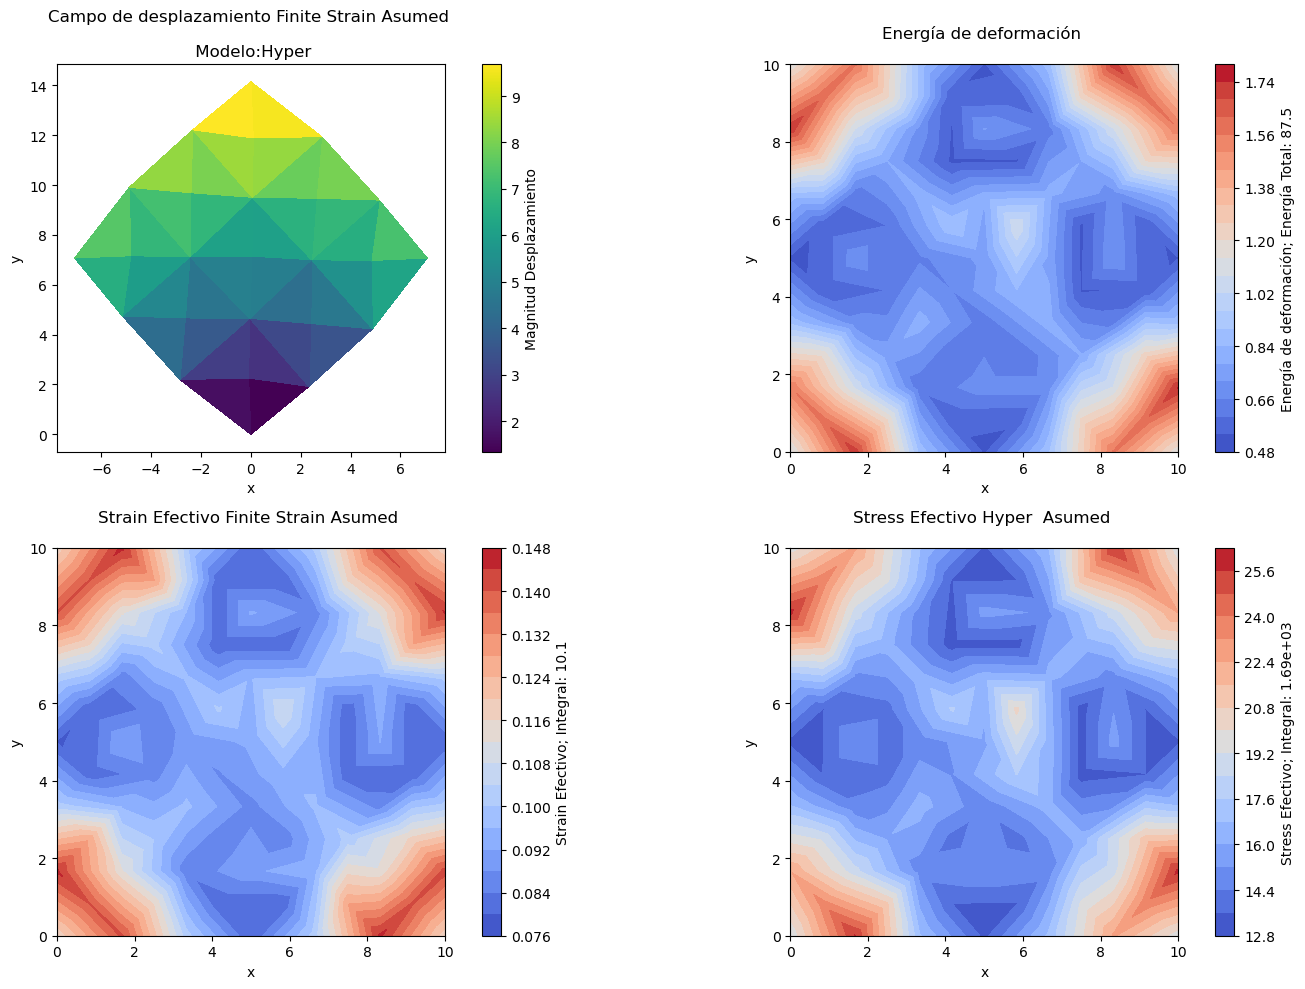

In [844]:
import matplotlib.pyplot as plt
import fenics as fe
import numpy as np

Nombre = Aprox + " Strain Asumed \n"


# Define tus variables eps y S
# Suponiendo que ya has definido tus funciones y variables necesarias

# Efective Strain:
Strain_eff = fe.inner(eps, eps)**0.5
stress_eff = fe.inner(S, S)**0.5

# Calcula la densidad de energía en cada punto de la malla de elementos finitos
Energy_density = 0.5 * fe.inner(eps, S)

# Define el espacio de funciones sobre la malla
V = fe.FunctionSpace(mesh, 'CG', 2)

# Interpola la densidad de energía, strain efectivo y stress efectivo en el espacio de funciones
Energy_density_func = fe.project(Energy_density, V)
Strain_eff_func = fe.project(Strain_eff, V)
stress_eff_func = fe.project(stress_eff, V)

# Convertir las funciones de FEniCS a matrices NumPy
X_values = fe.interpolate(fe.Expression('x[0]', degree=1), V).vector().get_local()
Y_values = fe.interpolate(fe.Expression('x[1]', degree=1), V).vector().get_local()
Energy_density_values = Energy_density_func.vector().get_local()
Strain_eff_values = Strain_eff_func.vector().get_local()
stress_eff_values = stress_eff_func.vector().get_local()

# Calculate the integrals over the domain
total_energy = fe.assemble(Energy_density_func * fe.dx)
total_strain_integral = fe.assemble(Strain_eff_func * fe.dx)
total_stress_integral = fe.assemble(stress_eff_func * fe.dx)

# Round the total energy, strain, and stress values to three significant figures
total_energy_str = "{:.3g}".format(total_energy)
total_strain_integral_str = "{:.3g}".format(total_strain_integral)
total_stress_integral_str = "{:.3g}".format(total_stress_integral)

print("Total energy in the domain:", total_energy)
print("Total strain integral:", total_strain_integral)
print("Total stress integral:", total_stress_integral)

# Plotea el campo de desplazamiento y la energía de deformación en el mismo gráfico
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Primer subgráfico: figura deformada con campo de desplazamiento
plt.sca(axs[0, 0])  # Establecer el eje activo
axs[0, 0].set_aspect('equal')  # Establecer las mismas proporciones en el espacio de trazado
P = fe.plot(u, mode="displacement")
plt.title("Campo de desplazamiento " + Nombre + "\n Modelo:"+Modelo )
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(P, ax=axs[0, 0], label="Magnitud Desplazamiento")

# Segundo subgráfico: energía de deformación
plt.sca(axs[0, 1])  # Establecer el eje activo
axs[0, 1].set_aspect('equal')  # Establecer las mismas proporciones en el espacio de trazado
contour1 = plt.tricontourf(X_values, Y_values, Energy_density_values, levels=20, cmap='coolwarm')
plt.title("Energía de deformación \n" )
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(contour1, ax=axs[0, 1], label="Energía de deformación; Energía Total: " + total_energy_str)

# Tercer subgráfico: strain efectivo
plt.sca(axs[1, 0])  # Establecer el eje activo
axs[1, 0].set_aspect('equal')  # Establecer las mismas proporciones en el espacio de trazado
contour2 = plt.tricontourf(X_values, Y_values, Strain_eff_values, levels=20, cmap='coolwarm')
plt.title("Strain Efectivo " + Nombre)
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(contour2, ax=axs[1, 0], label="Strain Efectivo; Integral: " + total_strain_integral_str)

# Cuarto subgráfico: stress efectivo
plt.sca(axs[1, 1])  # Establecer el eje activo
axs[1, 1].set_aspect('equal')  # Establecer las mismas proporciones en el espacio de trazado
contour3 = plt.tricontourf(X_values, Y_values, stress_eff_values, levels=20, cmap='coolwarm')
plt.title("Stress Efectivo " + Modelo +"  Asumed \n")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(contour3, ax=axs[1, 1], label="Stress Efectivo; Integral: " + total_stress_integral_str)

# Ajusta el diseño de los subgráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [764]:

# Definir el espacio de funciones para el tensor de deformación y los esfuerzos
W = fe.TensorFunctionSpace(mesh, 'CG', 1,shape=(2, 2))

# Crear una función para el tensor de deformación
strain_function = fe.Function(W, name="Strain")
strain_function.assign(fe.project(eps, W))

# Crear una función para los esfuerzos
stress_function = fe.Function(W, name="Stress")
stress_function.assign(fe.project(S, W))

# Guardar la solución, el tensor de deformación y los esfuerzos en archivos XDMF separados
with fe.XDMFFile("solucion.xdmf") as file:
    file.parameters["flush_output"] = True
    file.parameters["functions_share_mesh"] = True
    file.write(u,0.)
    file.write(strain_function,0.)
    file.write(stress_function,0.)


In [852]:
import fenics as fe
import ufl

#"Green" "Finite" "Henky"
Aprox = "Finite"

#"Lineal" "Hyper"
Modelo = "Hyper"

# Definir el cuadrado
L = 10  # Longitud del lado del cuadrado
Nmesh = 5
mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(L, L), Nmesh, Nmesh, diagonal="crossed")

# Definir el espacio de funciones
V = fe.VectorFunctionSpace(mesh, "CG", 1, dim=2)

# Definir condiciones de contorno
def boundary_bottom(x, on_boundary):
    return on_boundary and fe.near(x[1], 0) 

def boundary_top(x, on_boundary):
    return on_boundary and fe.near(x[1], L)

bc_bottom = fe.DirichletBC(V, fe.Constant((0, 0)), boundary_bottom)
bc_top = fe.DirichletBC(V, fe.Constant((0,0.36*L )), boundary_top)  # Desplazamiento en x = 1 en la parte superior
bcs = [bc_bottom, bc_top]

# Definir las variables
u = fe.Function(V)  # Desplazamiento
v = fe.TestFunction(V)  # Función de prueba

f = fe.Constant((0, 0))  # Fuerza de corte
T = fe.Constant((0, 0))  # Tensión de corte

# Definir las propiedades del material hiperelástico
E = 1e9  # Módulo de Young en Pa
nu = 0.3 # Coeficiente de Poisson

mu = E / (2.0 * (1.0 + nu))
lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

I = fe.Identity(2)  # Tensor de identidad
F = I + fe.grad(u)  # Tensor de deformación
C = F.T * F  # Tensor de deformación derecho o tensor de Cauchy-Green
J = fe.det(F)



if Aprox == "Finite":
    if Modelo == "Lineal":
        eps = fe.sym(fe.grad(u))
    elif Modelo=="Hyper":
        #Coordenadas Lagrangianas
        R=calcular_U(u)*fe.inv(F)
        eps = R*fe.sym(fe.grad(u))*R.T
elif Aprox == "Green":
    eps = 0.5 * (C - I)
elif Aprox == "Henky":
    # Debes proporcionar una implementación adecuada de calcular_epsilon(u)
    eps = calcular_epsilon(u)
else:
    raise ValueError("Aprox no coincide con ninguna condición válida.")

if Modelo == "Lineal":
    S = lmbda * fe.tr(eps) * I + 2.0 * mu * eps  # Tensor de esfuerzo de Piola-Kirchhoff
elif Modelo == "Hyper":
    J = fe.det(F)
    S = lmbda * fe.tr(eps)/J * I + 2.0 * (mu-ufl.ln(J))/J * eps  # Tensor de esfuerzo de Piola-Kirchhoff
else:
    raise ValueError("Modelo no coincide con ninguna condición válida.")

# Definir la energía potencial de deformación

W = 0.5 * fe.inner(S, eps) * fe.dx - fe.dot(T, v) * fe.ds - fe.dot(f, v) * fe.dx

# Definir la forma residual de la ecuación no lineal
F = fe.derivative(W, u, v)

# Resolver el problema de minimización de energía
fe.solve(F == 0, u, bcs, solver_parameters={'newton_solver': {'maximum_iterations': 100, 'relative_tolerance': 1e-6}})


                                                                                                                                                                                                                      No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                                                                      Differentiating residual form F to obtain Jacobian J = F'.
      Calling FFC just-in-time (JIT) compiler, this may take some time.


      Calling FFC just-in-time (JIT) compiler, this may take some time.
                                                                                                                                                                                                                      Solving nonlinear variational problem.
                                                                                                                                                                                                                        Newton iteration 0: r (abs) = 9.007e+08 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
                                                                                                                                                                                                                        Newton iteration 1: r (abs) = 3.937e+08 (tol = 1.000e-10) r (rel) = 4.372e-01 (tol = 1.000e-06)
                                                   

      Calling FFC just-in-time (JIT) compiler, this may take some time.
      Calling FFC just-in-time (JIT) compiler, this may take some time.
Total energy in the domain: 359658805.8088312
Total strain integral: 9.498231044274423
Total stress integral: 8324053557.86016


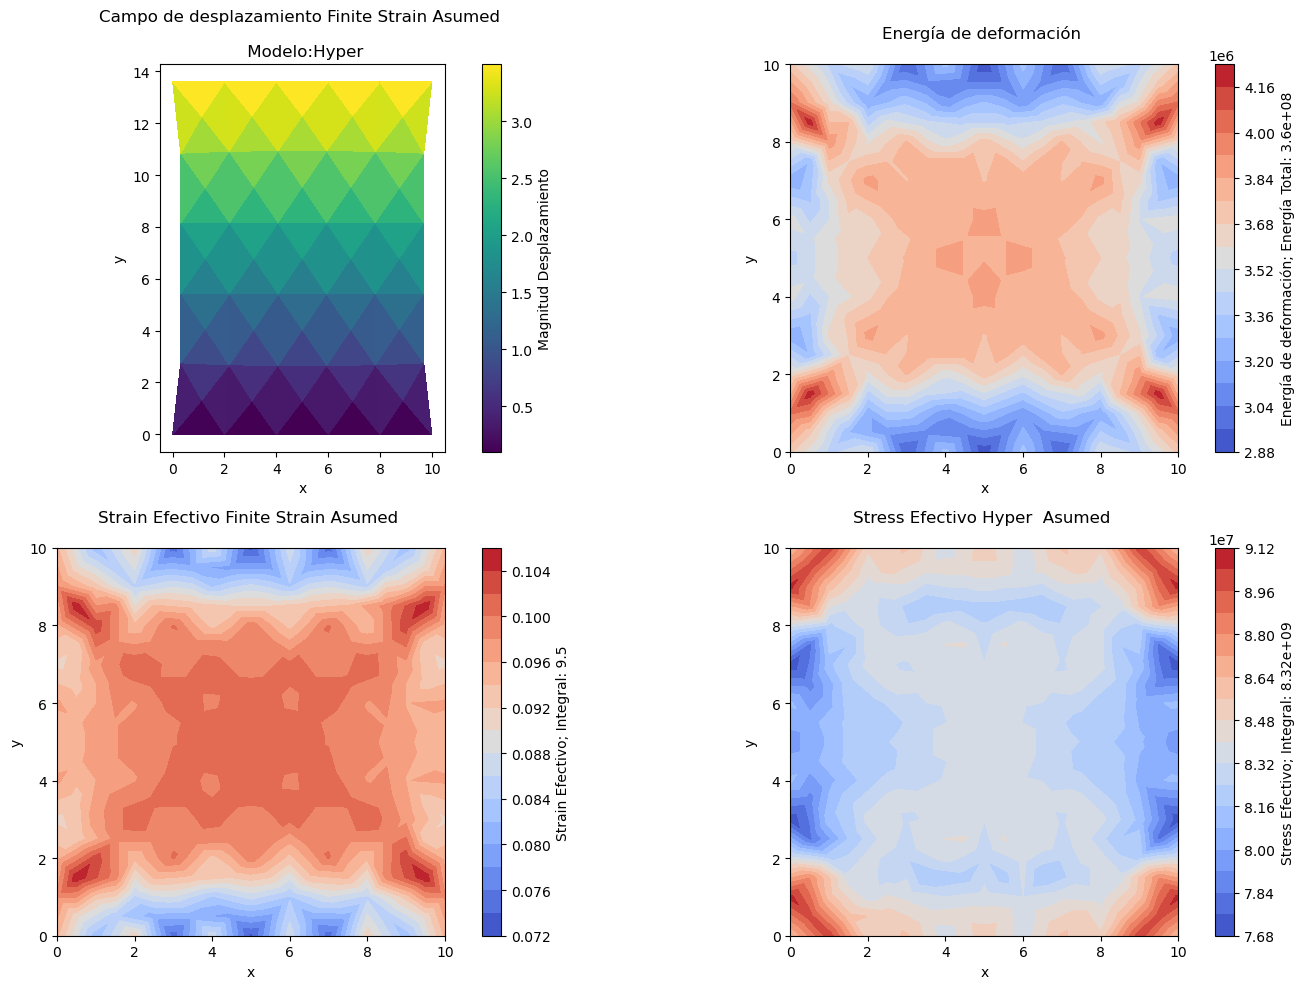

In [853]:
import matplotlib.pyplot as plt
import fenics as fe
import numpy as np

Nombre = Aprox + " Strain Asumed \n"


# Define tus variables eps y S
# Suponiendo que ya has definido tus funciones y variables necesarias

# Efective Strain:
Strain_eff = fe.inner(eps, eps)**0.5
stress_eff = fe.inner(S, S)**0.5

# Calcula la densidad de energía en cada punto de la malla de elementos finitos
Energy_density = 0.5 * fe.inner(eps, S)

# Define el espacio de funciones sobre la malla
V = fe.FunctionSpace(mesh, 'CG', 2)

# Interpola la densidad de energía, strain efectivo y stress efectivo en el espacio de funciones
Energy_density_func = fe.project(Energy_density, V)
Strain_eff_func = fe.project(Strain_eff, V)
stress_eff_func = fe.project(stress_eff, V)

# Convertir las funciones de FEniCS a matrices NumPy
X_values = fe.interpolate(fe.Expression('x[0]', degree=1), V).vector().get_local()
Y_values = fe.interpolate(fe.Expression('x[1]', degree=1), V).vector().get_local()
Energy_density_values = Energy_density_func.vector().get_local()
Strain_eff_values = Strain_eff_func.vector().get_local()
stress_eff_values = stress_eff_func.vector().get_local()

# Calculate the integrals over the domain
total_energy = fe.assemble(Energy_density_func * fe.dx)
total_strain_integral = fe.assemble(Strain_eff_func * fe.dx)
total_stress_integral = fe.assemble(stress_eff_func * fe.dx)

# Round the total energy, strain, and stress values to three significant figures
total_energy_str = "{:.3g}".format(total_energy)
total_strain_integral_str = "{:.3g}".format(total_strain_integral)
total_stress_integral_str = "{:.3g}".format(total_stress_integral)

print("Total energy in the domain:", total_energy)
print("Total strain integral:", total_strain_integral)
print("Total stress integral:", total_stress_integral)

# Plotea el campo de desplazamiento y la energía de deformación en el mismo gráfico
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Primer subgráfico: figura deformada con campo de desplazamiento
plt.sca(axs[0, 0])  # Establecer el eje activo
axs[0, 0].set_aspect('equal')  # Establecer las mismas proporciones en el espacio de trazado
P = fe.plot(u, mode="displacement")
plt.title("Campo de desplazamiento " + Nombre + "\n Modelo:"+Modelo )
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(P, ax=axs[0, 0], label="Magnitud Desplazamiento")

# Segundo subgráfico: energía de deformación
plt.sca(axs[0, 1])  # Establecer el eje activo
axs[0, 1].set_aspect('equal')  # Establecer las mismas proporciones en el espacio de trazado
contour1 = plt.tricontourf(X_values, Y_values, Energy_density_values, levels=20, cmap='coolwarm')
plt.title("Energía de deformación \n" )
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(contour1, ax=axs[0, 1], label="Energía de deformación; Energía Total: " + total_energy_str)

# Tercer subgráfico: strain efectivo
plt.sca(axs[1, 0])  # Establecer el eje activo
axs[1, 0].set_aspect('equal')  # Establecer las mismas proporciones en el espacio de trazado
contour2 = plt.tricontourf(X_values, Y_values, Strain_eff_values, levels=20, cmap='coolwarm')
plt.title("Strain Efectivo " + Nombre)
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(contour2, ax=axs[1, 0], label="Strain Efectivo; Integral: " + total_strain_integral_str)

# Cuarto subgráfico: stress efectivo
plt.sca(axs[1, 1])  # Establecer el eje activo
axs[1, 1].set_aspect('equal')  # Establecer las mismas proporciones en el espacio de trazado
contour3 = plt.tricontourf(X_values, Y_values, stress_eff_values, levels=20, cmap='coolwarm')
plt.title("Stress Efectivo " + Modelo +"  Asumed \n")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(contour3, ax=axs[1, 1], label="Stress Efectivo; Integral: " + total_stress_integral_str)

# Ajusta el diseño de los subgráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

                                                                                                                                                                Solving linear variational problem.
                                                                                                                                                                Object cannot be plotted directly, projecting to piecewise linears.
Maximal deflection: 0.005863753758493754
Beam theory deflection: 0.005859375
Stress at (0,H): [ 1.7274134  -0.22361951 -0.22361951  0.40196755]


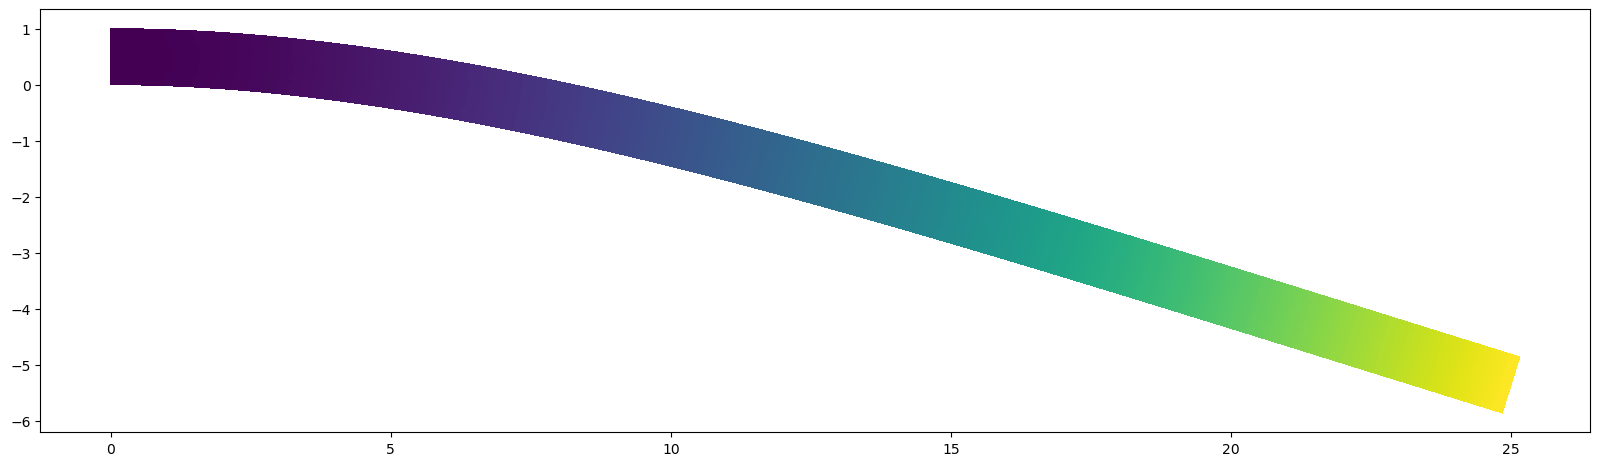

In [767]:

from dolfin import *

L = 25.
H = 1.
Nx = 250
Ny = 10
mesh = RectangleMesh(Point(0., 0.), Point(L, H), Nx, Ny, "crossed")

def eps(v):
    return sym(grad(v))

E = Constant(1e5)
nu = Constant(0.3)
model = "plane_stress"

mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
if model == "plane_stress":
    lmbda = 2*mu*lmbda/(lmbda+2*mu)

def sigma(v):
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

rho_g = 1e-3
f = Constant((0, -rho_g))

V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)
du = TrialFunction(V)
u_ = TestFunction(V)
a = inner(sigma(du), eps(u_))*dx
l = inner(f, u_)*dx


def left(x, on_boundary):
    return near(x[0], 0.)

bc = DirichletBC(V, Constant((0.,0.)), left)

u = Function(V, name="Displacement")
solve(a == l, u, bc)
plt.figure(figsize=(20, 10))
plot(1e3*u, mode="displacement")

print("Maximal deflection:", -u(L,H/2.)[1])
print("Beam theory deflection:", float(3*rho_g*L**4/2/E/H**3))


Vsig = TensorFunctionSpace(mesh, "DG", degree=0)
sig = Function(Vsig, name="Stress")
sig.assign(project(sigma(u), Vsig))
print("Stress at (0,H):", sig(0, H))


file_results = XDMFFile("elasticity_results.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
file_results.write(u, 0.)
file_results.write(sig, 0.)


In [791]:
import numpy as np
import fenics as fe
import ufl

def resolver_problema_elastico(E,nu,theta, Nmesh, L, Aprox="Finite", Modelo="Hyper"):
    # Definir el cuadrado
    mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(L, L), Nmesh, Nmesh, diagonal="crossed")

    # Definir el espacio de funciones
    V = fe.VectorFunctionSpace(mesh, "CG", 1, dim=2)

    # Definir las expresiones de rotación para cada esquina
    rot_topL = fe.Expression(("x[0]*cos(theta)-x[1]*sin(theta)","x[0]*sin(theta)+x[1]*cos(theta)-x[1]"), theta=theta, degree=0)
    rot_topR = fe.Expression(("x[0]*cos(theta)-x[1]*sin(theta)-x[0]","x[0]*sin(theta)+x[1]*cos(theta)-x[1]"), theta=theta, degree=0)
    rot_botR = fe.Expression(("x[0]*cos(theta)-x[1]*sin(theta)-x[0]","x[0]*sin(theta)+x[1]*cos(theta)"), theta=theta, degree=0)

    # Aplicar condiciones de contorno con rotación en cada esquina
    corner_fixed = fe.AutoSubDomain(lambda x: np.logical_and(fe.near(x[0], 0.0), fe.near(x[1], 0.0)))
    corner_topL = fe.AutoSubDomain(lambda x: np.logical_and(fe.near(x[0], 0.0), fe.near(x[1], L)))
    corner_topR = fe.AutoSubDomain(lambda x: np.logical_and(fe.near(x[0], L), fe.near(x[1], L)))
    corner_botR = fe.AutoSubDomain(lambda x: np.logical_and(fe.near(x[0], L), fe.near(x[1], 0.0)))

    bc_fixed_corner = fe.DirichletBC(V, fe.Constant((0., 0.)), corner_fixed, method='pointwise')  
    bc_topL = fe.DirichletBC(V, rot_topL, corner_topL, method='pointwise') 
    bc_topR = fe.DirichletBC(V, rot_topR, corner_topR, method='pointwise') 
    bc_botR = fe.DirichletBC(V, rot_botR, corner_botR, method='pointwise') 

    bcs = [bc_fixed_corner, bc_topL, bc_topR, bc_botR]

    # Definir las variables
    u = fe.Function(V, name="Displacement")  # Desplazamiento
    v = fe.TestFunction(V)  # Función de prueba

    f = fe.Constant((0, 0))  # Fuerza de corte
    T = fe.Constant((0, 0))  # Tensión de corte

    # Definir las propiedades del material hiperelástico
    mu = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

    I = fe.Identity(2)  # Tensor de identidad
    F = I + fe.grad(u)  # Tensor de deformación
    C = fe.variable(F.T * F)  # Tensor de deformación derecho o tensor de Cauchy-Green

    if Aprox == "Finite":
        if Modelo == "Lineal":
            eps = fe.sym(fe.grad(u))
        elif Modelo=="Hyper":
            #Coordenadas Lagrangianas
            R=calcular_U(u)*fe.inv(F)
            eps = R*fe.sym(fe.grad(u))*R.T
    elif Aprox == "Green":
        eps = 0.5 * (C - I)
    elif Aprox == "Henky":
        # Debes proporcionar una implementación adecuada de calcular_epsilon(u)
        eps = calcular_epsilon(u)
    else:
        raise ValueError("Aprox no coincide con ninguna condición válida.")

    if Modelo == "Lineal":
        S = lmbda * fe.tr(eps) * I + 2.0 * mu * eps  # Tensor de esfuerzo de Piola-Kirchhoff
    elif Modelo == "Hyper":
        J = fe.det(F)
        S = lmbda * fe.tr(eps)/J * I + 2.0 * (mu-ufl.ln(J))/J * eps  # Tensor de esfuerzo de Piola-Kirchhoff
    else:
        raise ValueError("Modelo no coincide con ninguna condición válida.")

    # Definir la energía potencial de deformación
    W = 0.5 * fe.inner(S, eps) * fe.dx - fe.dot(T, v) * fe.ds - fe.dot(f, v) * fe.dx 

    # Definir la forma residual de la ecuación no lineal
    F = fe.derivative(W, u, v)

    # Resolver el problema de minimización de energía
    fe.solve(F == 0, u, bcs, solver_parameters={'newton_solver': {'maximum_iterations': 100}})

    return u
############################################################################################################################33
def resolver_problema_elastico_C(E,nu,D, Nmesh, L, Aprox="Finite", Modelo="Hyper"):
    mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(L, L), Nmesh, Nmesh, diagonal="crossed")

    # Definir el espacio de funciones
    V = fe.VectorFunctionSpace(mesh, "CG", 1, dim=2)

    # Definir condiciones de contorno
    def boundary_bottom(x, on_boundary):
        return on_boundary and fe.near(x[1], 0) 

    def boundary_top(x, on_boundary):
        return on_boundary and fe.near(x[1], L)

    bc_bottom = fe.DirichletBC(V, fe.Constant((0, 0)), boundary_bottom)
    bc_top = fe.DirichletBC(V, fe.Constant((D,0)), boundary_top)  # Desplazamiento en x = 1 en la parte superior
    bcs = [bc_bottom, bc_top]

    # Definir las variables
    u = fe.Function(V)  # Desplazamiento
    v = fe.TestFunction(V)  # Función de prueba

    f = fe.Constant((0, 0))  # Fuerza de corte
    T = fe.Constant((0, 0))  # Tensión de corte

    mu = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

    I = fe.Identity(2)  # Tensor de identidad
    F = I + fe.grad(u)  # Tensor de deformación
    C = F.T * F  # Tensor de deformación derecho o tensor de Cauchy-Green
    J = fe.det(F)

    if Aprox == "Finite":
        if Modelo == "Lineal":
            eps = fe.sym(fe.grad(u))
        elif Modelo=="Hyper":
            #Coordenadas Lagrangianas
            R=calcular_U(u)*fe.inv(F)
            eps = R*fe.sym(fe.grad(u))*R.T
    elif Aprox == "Green":
        eps = 0.5 * (C - I)
    elif Aprox == "Henky":
        # Debes proporcionar una implementación adecuada de calcular_epsilon(u)
        eps = calcular_epsilon(u)
    else:
        raise ValueError("Aprox no coincide con ninguna condición válida.")

    if Modelo == "Lineal":
        S = lmbda * fe.tr(eps) * I + 2.0 * mu * eps  # Tensor de esfuerzo de Piola-Kirchhoff
    elif Modelo == "Hyper":
        J = fe.det(F)
        S = lmbda * fe.tr(eps)/J * I + 2.0 * (mu-ufl.ln(J))/J * eps  # Tensor de esfuerzo de Piola-Kirchhoff
    else:
        raise ValueError("Modelo no coincide con ninguna condición válida.")

    # Definir la energía potencial de deformación
    W = 0.5*fe.inner(S, eps) * fe.dx - fe.dot(T, v) * fe.ds - fe.dot(f, v) * fe.dx 

    # Definir la forma residual de la ecuación no lineal
    F = fe.derivative(W, u, v)

    # Resolver el problema de minimización de energía
    fe.solve(F == 0, u,bcs, solver_parameters={'newton_solver': {'maximum_iterations': 100}})

    return u

##########################################################################################################################################################################
def resolver_problema_elastico_T(E,nu,D, Nmesh, L, Aprox="Finite", Modelo="Hyper"):
    mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(L, L), Nmesh, Nmesh, diagonal="crossed")

    # Definir el espacio de funciones
    V = fe.VectorFunctionSpace(mesh, "CG", 1, dim=2)

    # Definir condiciones de contorno
    def boundary_bottom(x, on_boundary):
        return on_boundary and fe.near(x[1], 0) 

    def boundary_top(x, on_boundary):
        return on_boundary and fe.near(x[1], L)

    bc_bottom = fe.DirichletBC(V, fe.Constant((0, 0)), boundary_bottom)
    bc_top = fe.DirichletBC(V, fe.Constant((0,D)), boundary_top)  # Desplazamiento en x = 1 en la parte superior
    bcs = [bc_bottom, bc_top]

    # Definir las variables
    u = fe.Function(V)  # Desplazamiento
    v = fe.TestFunction(V)  # Función de prueba

    f = fe.Constant((0, 0))  # Fuerza de corte
    T = fe.Constant((0, 0))  # Tensión de corte

    mu = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

    I = fe.Identity(2)  # Tensor de identidad
    F = I + fe.grad(u)  # Tensor de deformación
    C = F.T * F  # Tensor de deformación derecho o tensor de Cauchy-Green
    J = fe.det(F)

    if Aprox == "Finite":
        if Modelo == "Lineal":
            eps = fe.sym(fe.grad(u))
        elif Modelo=="Hyper":
            #Coordenadas Lagrangianas
            R=calcular_U(u)*fe.inv(F)
            eps = R*fe.sym(fe.grad(u))*R.T
    elif Aprox == "Green":
        eps = 0.5 * (C - I)
    elif Aprox == "Henky":
        # Debes proporcionar una implementación adecuada de calcular_epsilon(u)
        eps = calcular_epsilon(u)
    else:
        raise ValueError("Aprox no coincide con ninguna condición válida.")

    if Modelo == "Lineal":
        S = lmbda * fe.tr(eps) * I + 2.0 * mu * eps  # Tensor de esfuerzo de Piola-Kirchhoff
    elif Modelo == "Hyper":
        J = fe.det(F)
        S = lmbda * fe.tr(eps)/J * I + 2.0 * (mu-ufl.ln(J))/J * eps  # Tensor de esfuerzo de Piola-Kirchhoff
    else:
        raise ValueError("Modelo no coincide con ninguna condición válida.")

    # Definir la energía potencial de deformación
    W = 0.5*fe.inner(S, eps) * fe.dx - fe.dot(T, v) * fe.ds - fe.dot(f, v) * fe.dx 

    # Definir la forma residual de la ecuación no lineal
    F = fe.derivative(W, u, v)

    # Resolver el problema de minimización de energía
    fe.solve(F == 0, u,bcs, solver_parameters={'newton_solver': {'maximum_iterations': 100}})

    return u
###############################################################################################################################33
def calcular_tension_efectiva(u,E,nu,Aprox, Modelo):
    I = fe.Identity(2)
    F = I + fe.grad(u)
    C = fe.variable(F.T * F)

    mu = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

    if Aprox == "Finite":
        if Modelo == "Lineal":
            eps = fe.sym(fe.grad(u))
        elif Modelo=="Hyper":
            #Coordenadas Lagrangianas
            R=calcular_U(u)*fe.inv(F)
            eps = R*fe.sym(fe.grad(u))*R.T
    elif Aprox == "Green":
        eps = 0.5 * (C - I)
    elif Aprox == "Henky":
        # Debes proporcionar una implementación adecuada de calcular_epsilon(u)
        eps = calcular_epsilon(u)
    else:
        raise ValueError("Aprox no coincide con ninguna condición válida.")

    if Modelo == "Lineal":
        S = lmbda * fe.tr(eps) * I + 2.0 * mu * eps
    elif Modelo == "Hyper":
        J = fe.det(F)
        S = lmbda * fe.tr(eps)/J * I + 2.0 * (mu-ufl.ln(J))/J * eps
    else:
        raise ValueError("Modelo no coincide con ninguna condición válida.")
    return fe.inner(S, S)**0.5


def calcular_deformacion_efectiva(u,E,nu,Aprox, Modelo):
    I = fe.Identity(2)
    F = I + fe.grad(u)
    C = fe.variable(F.T * F)
    mu = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

    if Aprox == "Finite":
        if Modelo == "Lineal":
            eps = fe.sym(fe.grad(u))
        elif Modelo=="Hyper":
            #Coordenadas Lagrangianas
            R=calcular_U(u)*fe.inv(F)
            eps = R*fe.sym(fe.grad(u))*R.T
    elif Aprox == "Green":
        eps = 0.5 * (C - I)
    elif Aprox == "Henky":
        # Debes proporcionar una implementación adecuada de calcular_epsilon(u)
        eps = calcular_epsilon(u)
    else:
        raise ValueError("Aprox no coincide con ninguna condición válida.")

    if Modelo == "Lineal":
        S = lmbda * fe.tr(eps) * I + 2.0 * mu * eps
    elif Modelo == "Hyper":
        J = fe.det(F)
        S = lmbda * fe.tr(eps)/J * I + 2.0 * (mu-ufl.ln(J))/J * eps
    else:
        raise ValueError("Modelo no coincide con ninguna condición válida.")
    return  fe.inner(eps, eps)**0.5

def calcular_energia_desformacion(u, E, nu, Aprox, Modelo):
    I = fe.Identity(2)
    F = I + fe.grad(u)
    C = fe.variable(F.T * F)
    mu = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

    if Aprox == "Finite":
        if Modelo == "Lineal":
            eps = fe.sym(fe.grad(u))
        elif Modelo=="Hyper":
            #Coordenadas Lagrangianas
            R=calcular_U(u)*fe.inv(F)
            eps = R*fe.sym(fe.grad(u))*R.T
    elif Aprox == "Green":
        eps = 0.5 * (C - I)
    elif Aprox == "Henky":
        # Debes proporcionar una implementación adecuada de calcular_epsilon(u)
        eps = calcular_epsilon(u)
    else:
        raise ValueError("Aprox no coincide con ninguna condición válida.")

    if Modelo == "Lineal":
        S = lmbda * fe.tr(eps) * I + 2.0 * mu * eps
    elif Modelo == "Hyper":
        J = fe.det(F)
        S = lmbda * fe.tr(eps)/J * I + 2.0 * (mu-ufl.ln(J))/J * eps
    else:
        raise ValueError("Modelo no coincide con ninguna condición válida.")

    return 0.5 * fe.inner(eps, S)

In [878]:
import numpy as np
import fenics as fe
import matplotlib.pyplot as plt
import imageio

# Configuración para el GIF
num_frames = 120
theta_max = np.pi *0.25
Nmesh = 3
L = 1
E=100
nu=0.3
Aprox="Finite"
Modelo="Hyper"
# Crear una lista para almacenar los frames del GIF
frames = []

for i in range(num_frames):
    # Calcular el ángulo theta para este frame
    theta = (i / (num_frames - 1)) * theta_max

    # Resolver el problema elástico con el ángulo theta actual
    desplazamiento = resolver_problema_elastico(E,nu,theta, Nmesh, L, Aprox, Modelo)

    # Definir la malla cuadrada original
    mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(L, L), Nmesh, Nmesh, "crossed")

    # Deformar la malla aplicando el desplazamiento
    V = fe.VectorFunctionSpace(mesh, "CG", 1)
    u = fe.Function(V)
    u.vector()[:] = desplazamiento.vector()
    mesh = fe.Mesh(mesh)
    fe.ALE.move(mesh, u)

    # Crear una figura y trazar la malla deformada
    fig, ax = plt.subplots()
    fe.plot(mesh)
    ax.set_title(f"Deformación con theta={theta:.2f}"+"  Modelo "+Aprox+" "+Modelo)
    ax.set_xlim(-1.5*L, 1.5*L)
    ax.set_ylim(-1.5*L, 1.5*L)
    ax.set_aspect('equal', 'box')
    
    # Guardar el frame actual en la lista de frames
    plt.tight_layout()
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)

    plt.close(fig)

# Guardar los frames como un GIF
imageio.mimsave('deformacion.gif', frames, fps=10)

print("GIF generado con éxito.")


                                                                                                                                                                                                                                                    No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                                                                                                    Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                                                                                                    Solving nonlinear variational problem.
                                                                                                            

/tmp/ipykernel_407527/4232864145.py:46: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


                                                                                                                                                                                                                                                    No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                                                                                                    Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                                                                                                    Solving nonlinear variational problem.
                                                                                                            

In [770]:
import numpy as np
import fenics as fe
import matplotlib.pyplot as plt
import imageio

# Configuración para el GIF
num_frames = 120
Nmesh = 10
L = 1
D_max = L*0.35
E=100
nu=0.3
Aprox="Finite"
Modelo="Lineal"
# Crear una lista para almacenar los frames del GIF
frames = []

for i in range(num_frames):
    # Calcular el ángulo theta para este frame
    D = (i / (num_frames - 1)) * D_max

    # Resolver el problema elástico con el ángulo theta actual
    desplazamiento = resolver_problema_elastico_C(E,nu,D, Nmesh, L, Aprox, Modelo)

    # Definir la malla cuadrada original
    mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(L, L), Nmesh, Nmesh, "crossed")

    # Deformar la malla aplicando el desplazamiento
    V = fe.VectorFunctionSpace(mesh, "CG", 1)
    u = fe.Function(V)
    u.vector()[:] = desplazamiento.vector()
    mesh = fe.Mesh(mesh)
    fe.ALE.move(mesh, u)

    # Crear una figura y trazar la malla deformada
    fig, ax = plt.subplots()
    fe.plot(mesh)
    ax.set_title(f"Deformación con D={D:.2f}"+"  Modelo "+Aprox+" "+Modelo)
    ax.set_xlim(-L/10, 1.1*D_max+L)
    ax.set_ylim(-L/10, 1.1*L)
    ax.set_aspect('equal', 'box')
    
    # Guardar el frame actual en la lista de frames
    plt.tight_layout()
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)

    plt.close(fig)

# Guardar los frames como un GIF
imageio.mimsave('deformacion_C.gif', frames, fps=10)

print("GIF generado con éxito.")


                                                                                                                                                                No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                Solving nonlinear variational problem.
                                                                                                                                                                  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
                                                                                                           

/tmp/ipykernel_407527/2006473767.py:46: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


                                                                                                                                                                No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                Solving nonlinear variational problem.
                                                                                                                                                                  Newton iteration 0: r (abs) = 6.673e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
                                                                                                      

In [771]:
frames = []

for i in range(num_frames):
    # Calcular el valor de D para este frame
    D = (i / (num_frames - 1)) * D_max

    # Resolver el problema elástico con el valor de D actual
    desplazamiento = resolver_problema_elastico_C(E, nu, D, Nmesh, L, Aprox, Modelo)

    # Definir la malla cuadrada original
    mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(L, L), Nmesh, Nmesh, "crossed")

    # Deformar la malla aplicando el desplazamiento
    V = fe.VectorFunctionSpace(mesh, "CG", 1)
    u = fe.Function(V)
    u.vector()[:] = desplazamiento.vector()
    mesh = fe.Mesh(mesh)
    fe.ALE.move(mesh, u)

    # Calcular la energía de deformación en la malla deformada
    energy_density = calcular_energia_desformacion(u, E, nu, Aprox, Modelo)

    # Crear una figura y trazar el campo de energía
    fig, ax = plt.subplots()
    fe.plot(energy_density)
    plt.colorbar(ax.collections[0], ax=ax)  # Agregar barra de color
    ax.set_title(f"Campo de energía de deformación con D={D:.2f}")
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal', 'box')
    
    # Guardar el frame actual en la lista de frames
    plt.tight_layout()
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)

    plt.close(fig)

# Guardar los frames como un GIF
imageio.mimsave('campo_energia_deformacion_C.gif', frames, fps=10)

print("GIF generado con éxito.")


                                                                                                                                                                No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                Solving nonlinear variational problem.
                                                                                                                                                                  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
                                                                                                           

/tmp/ipykernel_407527/1816930192.py:35: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


                                                                                                                                                                No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                Solving nonlinear variational problem.
                                                                                                                                                                  Newton iteration 0: r (abs) = 5.005e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
                                                                                                      

In [772]:
import numpy as np
import fenics as fe
import matplotlib.pyplot as plt
import imageio

# Configuración para el GIF
num_frames = 120
Nmesh = 10
L = 1
D_max = L*0.57
E=100
nu=0.3
Aprox="Finite"
Modelo="Lineal"
# Crear una lista para almacenar los frames del GIF
frames = []

for i in range(num_frames):
    # Calcular el ángulo theta para este frame
    D  = (i / (num_frames - 1)) * D_max

    # Resolver el problema elástico con el ángulo theta actual
    desplazamiento = resolver_problema_elastico_T(E,nu,D, Nmesh, L, Aprox, Modelo)

    # Definir la malla cuadrada original
    mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(L, L), Nmesh, Nmesh, "crossed")

    # Deformar la malla aplicando el desplazamiento
    V = fe.VectorFunctionSpace(mesh, "CG", 1)
    u = fe.Function(V)
    u.vector()[:] = desplazamiento.vector()
    mesh = fe.Mesh(mesh)
    fe.ALE.move(mesh, u)

    # Crear una figura y trazar la malla deformada
    fig, ax = plt.subplots()
    fe.plot(mesh)
    ax.set_title(f"Deformación con D={D:.2f}"+"  Modelo "+Aprox+" "+Modelo)
    ax.set_xlim(-L/10,1.1*L)
    ax.set_ylim(-L/10, 1.1*D_max+L*1.1)
    ax.set_aspect('equal', 'box')
    
    # Guardar el frame actual en la lista de frames
    plt.tight_layout()
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)

    plt.close(fig)

# Guardar los frames como un GIF
imageio.mimsave('deformacion_T.gif', frames, fps=10)

print("GIF generado con éxito.")

                                                                                                                                                                No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                Solving nonlinear variational problem.
                                                                                                                                                                  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
                                                                                                           

/tmp/ipykernel_407527/2529013666.py:46: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


                                                                                                                                                                No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                Solving nonlinear variational problem.
                                                                                                                                                                  Newton iteration 0: r (abs) = 1.087e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
                                                                                                      

In [773]:
frames = []

for i in range(num_frames):
    # Calcular el valor de D para este frame
    D = (i / (num_frames - 1)) * D_max

    # Resolver el problema elástico con el valor de D actual
    desplazamiento = resolver_problema_elastico_T(E, nu, D, Nmesh, L, Aprox, Modelo)

    # Definir la malla cuadrada original
    mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(L, L), Nmesh, Nmesh, "crossed")

    # Deformar la malla aplicando el desplazamiento
    V = fe.VectorFunctionSpace(mesh, "CG", 1)
    u = fe.Function(V)
    u.vector()[:] = desplazamiento.vector()
    mesh = fe.Mesh(mesh)
    fe.ALE.move(mesh, u)

    # Calcular la energía de deformación en la malla deformada
    energy_density = calcular_energia_desformacion(u, E, nu, Aprox, Modelo)

    # Crear una figura y trazar el campo de energía
    fig, ax = plt.subplots()
    fe.plot(energy_density)
    plt.colorbar(ax.collections[0], ax=ax)  # Agregar barra de color
    ax.set_title(f"Campo de energía de deformación con D={D:.2f}")
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal', 'box')
    
    # Guardar el frame actual en la lista de frames
    plt.tight_layout()
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)

    plt.close(fig)

# Guardar los frames como un GIF
imageio.mimsave('campo_energia_deformacion_T.gif', frames, fps=10)

print("GIF generado con éxito.")




                                                                                                                                                                No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                Solving nonlinear variational problem.
                                                                                                                                                                  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
                                                                                                           

/tmp/ipykernel_407527/2656046628.py:35: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


                                                                                                                                                                No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                Solving nonlinear variational problem.
                                                                                                                                                                  Newton iteration 0: r (abs) = 8.150e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
                                                                                                      

<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_407527/552508950.py:45: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_xlabel('Theta \pi')


                                                                                                                                                                                                                                                    No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                                                                                                    Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                                                                                                    Solving nonlinear variational problem.
                                                                                                            

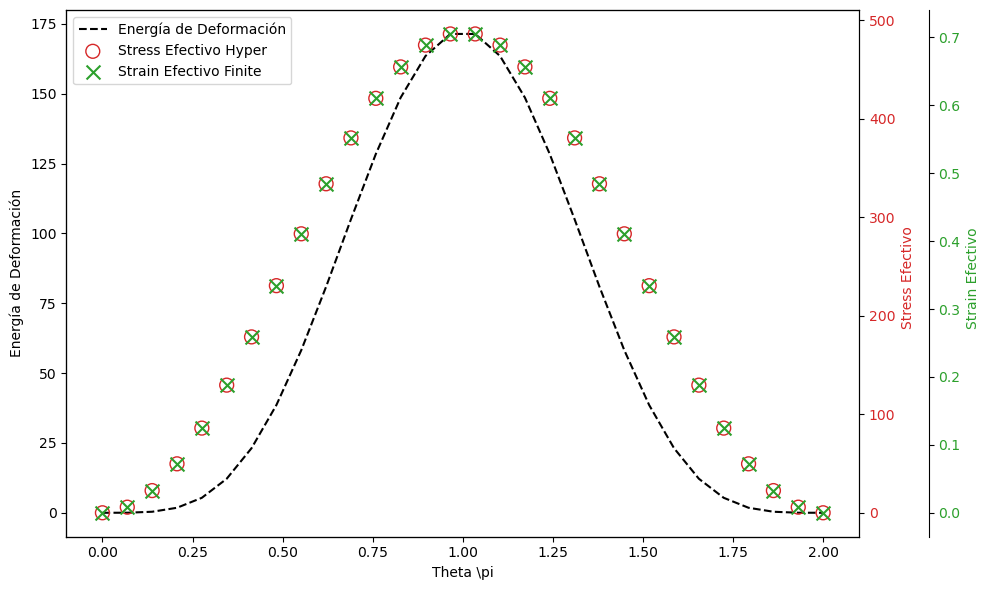

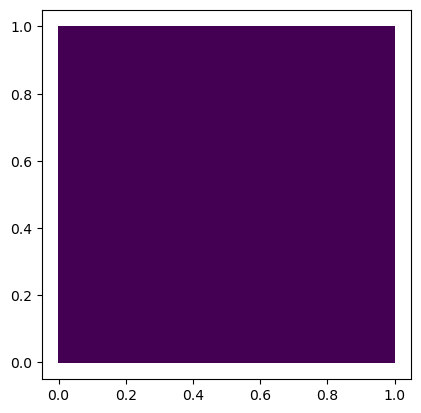

In [879]:
import numpy as np
import matplotlib.pyplot as plt

Nmesh = 1
L = 1
E=100
nu=0.45
Aprox="Finite"
Modelo="Hyper"
# Crear una lista para almacenar los frames del GIF
frames = []

# Definir una lista de valores de theta
num_theta_values = 30
theta_values = np.linspace(0, np.pi / 0.5, num_theta_values)

# Listas para almacenar los resultados
integral_energia_deformacion = []
integral_strain_efectivo = []
integral_stress_efectivo = []

# Calcular las integrales para cada valor de theta
for theta in theta_values:
    # Resolver el problema elástico y calcular las cantidades necesarias
    desplazamiento = resolver_problema_elastico(E, nu,theta, Nmesh, L, Aprox, Modelo)
    energia_deformacion = calcular_energia_desformacion(desplazamiento, E, nu,Aprox, Modelo)
    strain_efectivo = calcular_deformacion_efectiva(desplazamiento, E, nu, Aprox, Modelo)
    stress_efectivo = calcular_tension_efectiva(desplazamiento, E, nu, Aprox, Modelo)
    
    # Calcular las integrales sobre el dominio
    integral_energia_deformacion.append(fe.assemble(energia_deformacion * fe.dx))
    integral_strain_efectivo.append(fe.assemble(strain_efectivo * fe.dx))
    integral_stress_efectivo.append(fe.assemble(stress_efectivo * fe.dx))

# Convertir las listas en arrays de NumPy
integral_energia_deformacion = np.array(integral_energia_deformacion)
integral_strain_efectivo = np.array(integral_strain_efectivo)
integral_stress_efectivo = np.array(integral_stress_efectivo)

# Graficar los resultados
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la integral de energía de deformación
ax1.plot(theta_values/np.pi, integral_energia_deformacion, '--', color='black', label='Energía de Deformación')
ax1.set_xlabel('Theta \pi')
ax1.set_ylabel('Energía de Deformación', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Crear un segundo eje y comparte el mismo x
ax2 = ax1.twinx()

# Graficar el stress efectivo
ax2.scatter(theta_values/np.pi, integral_stress_efectivo, marker='o', facecolors='none', edgecolors='tab:red', s=100, label='Stress Efectivo '+ Modelo)
ax2.set_ylabel('Stress Efectivo  ' , color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Crear un tercer eje y comparte el mismo x
ax3 = ax1.twinx()

# Graficar el strain efectivo
ax3.scatter(theta_values/np.pi, integral_strain_efectivo, marker='x', color='tab:green', s=100, label='Strain Efectivo ' + Aprox)
ax3.set_ylabel('Strain Efectivo  ' , color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Ajustar la posición del tercer eje
ax3.spines['right'].set_position(('outward', 50))

# Ajustar el diseño de la leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines = lines1 + lines2 + lines3
labels = labels1 + labels2 + labels3
ax1.legend(lines, labels, loc='upper left')

fig.tight_layout()
plt.show()

fe.plot(desplazamiento,mode="displacement")

                                                                                                                                                                                                                                                    No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                                                                                                    Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                                                                                                    Solving nonlinear variational problem.
                                                                                                            

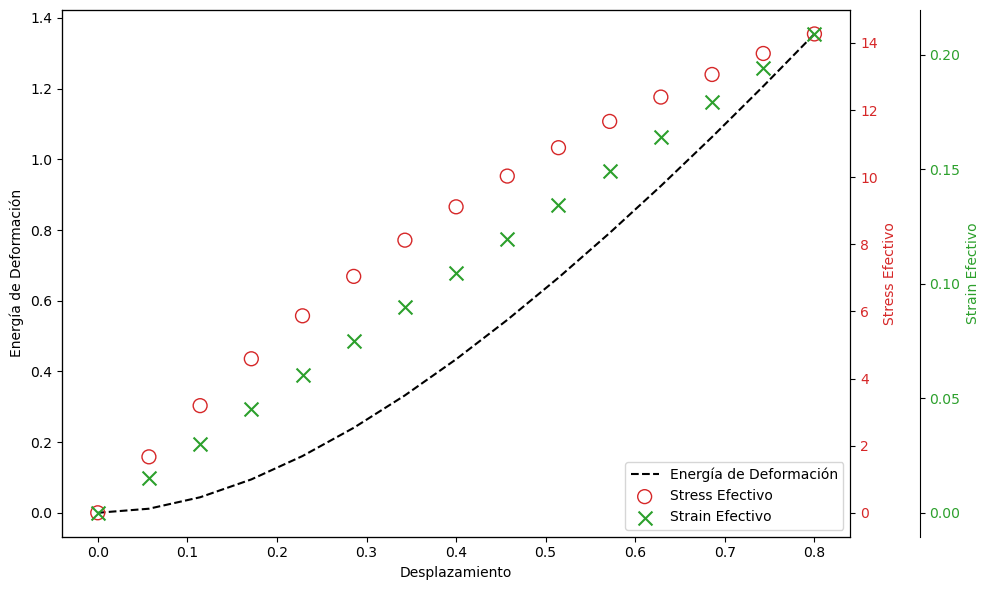

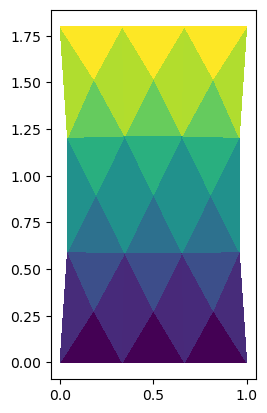

In [882]:
import numpy as np
import matplotlib.pyplot as plt

# Definir una lista de valores de theta
L=1
E=100
nu=0.3
Nmesh=3
Aprox="Finite"
Modelo="Hyper"
D_max=15
D_values = np.linspace(0, L*0.8, D_max)

# Listas para almacenar los resultados
integral_energia_deformacion = []
integral_strain_efectivo = []
integral_stress_efectivo = []

# Calcular las integrales para cada valor de theta
for D in D_values:
    
    # Resolver el problema elástico y calcular las cantidades necesarias
    desplazamiento = resolver_problema_elastico_T(E, nu,D, Nmesh, L, Aprox, Modelo)
    energia_deformacion = calcular_energia_desformacion(desplazamiento, E, nu,  Aprox, Modelo)
    strain_efectivo = calcular_deformacion_efectiva(desplazamiento, E, nu,  Aprox, Modelo)
    stress_efectivo = calcular_tension_efectiva(desplazamiento, E, nu,  Aprox, Modelo)
    
    # Calcular las integrales sobre el dominio
    integral_energia_deformacion.append(fe.assemble(energia_deformacion * fe.dx))
    integral_strain_efectivo.append(fe.assemble(strain_efectivo * fe.dx))
    integral_stress_efectivo.append(fe.assemble(stress_efectivo * fe.dx))

# Convertir las listas en arrays de NumPy
integral_energia_deformacion = np.array(integral_energia_deformacion)
integral_strain_efectivo = np.array(integral_strain_efectivo)
integral_stress_efectivo = np.array(integral_stress_efectivo)

# Graficar los resultados
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la integral de energía de deformación
ax1.plot(D_values, integral_energia_deformacion, '--', color='black', label='Energía de Deformación')
ax1.set_xlabel('Desplazamiento')
ax1.set_ylabel('Energía de Deformación', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Crear un segundo eje y comparte el mismo x
ax2 = ax1.twinx()

# Graficar el stress efectivo
ax2.scatter(D_values, integral_stress_efectivo, marker='o', facecolors='none', edgecolors='tab:red', s=100, label='Stress Efectivo')
ax2.set_ylabel('Stress Efectivo', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Crear un tercer eje y comparte el mismo x
ax3 = ax1.twinx()

# Graficar el strain efectivo
ax3.scatter(D_values, integral_strain_efectivo, marker='x', color='tab:green', s=100, label='Strain Efectivo')
ax3.set_ylabel('Strain Efectivo', color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Ajustar la posición del tercer eje
ax3.spines['right'].set_position(('outward', 50))

# Ajustar el diseño de la leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines = lines1 + lines2 + lines3
labels = labels1 + labels2 + labels3
ax1.legend(lines, labels, loc='lower right')

fig.tight_layout()
plt.show()


fe.plot(desplazamiento,mode="displacement")

                                                                                                                                                                                                                                                    No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                                                                                                    Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                                                                                                    Solving nonlinear variational problem.
                                                                                                            

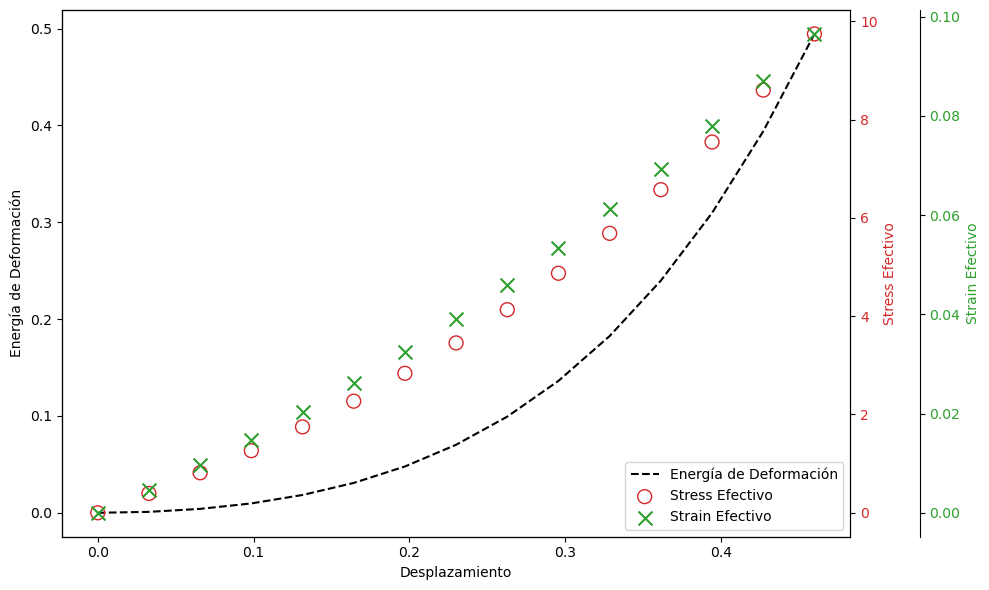

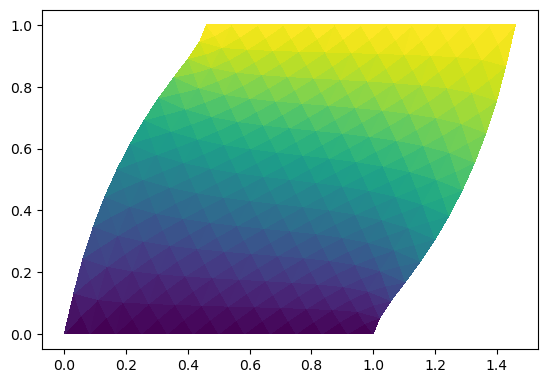

In [883]:
import numpy as np
import matplotlib.pyplot as plt

# Definir una lista de valores de theta
L=1
E=100
nu=0.3
Nmesh=12
Aprox="Finite"
Modelo="Hyper"
D_max=15
D_values = np.linspace(0, L*0.46, D_max)

# Listas para almacenar los resultados
integral_energia_deformacion = 0
integral_strain_efectivo = 0
integral_stress_efectivo = 0

integral_energia_deformacion = []
integral_strain_efectivo = []
integral_stress_efectivo = []

# Calcular las integrales para cada valor de theta
for D in D_values:
    # Resolver el problema elástico y calcular las cantidades necesarias
    desplazamiento = resolver_problema_elastico_C(E, nu,D, Nmesh, L, Aprox, Modelo)
    energia_deformacion = calcular_energia_desformacion(desplazamiento, E, nu,  Aprox, Modelo)
    strain_efectivo = calcular_deformacion_efectiva(desplazamiento, E, nu,  Aprox, Modelo)
    stress_efectivo = calcular_tension_efectiva(desplazamiento, E, nu,  Aprox, Modelo)
    
    # Calcular las integrales sobre el dominio
    integral_energia_deformacion.append(fe.assemble(energia_deformacion * fe.dx))
    integral_strain_efectivo.append(fe.assemble(strain_efectivo * fe.dx))
    integral_stress_efectivo.append(fe.assemble(stress_efectivo * fe.dx))

# Convertir las listas en arrays de NumPy
integral_energia_deformacion = np.array(integral_energia_deformacion)
integral_strain_efectivo = np.array(integral_strain_efectivo)
integral_stress_efectivo = np.array(integral_stress_efectivo)

# Graficar los resultados
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la integral de energía de deformación
ax1.plot(D_values, integral_energia_deformacion, '--', color='black', label='Energía de Deformación')
ax1.set_xlabel('Desplazamiento')
ax1.set_ylabel('Energía de Deformación', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Crear un segundo eje y comparte el mismo x
ax2 = ax1.twinx()

# Graficar el stress efectivo
ax2.scatter(D_values, integral_stress_efectivo, marker='o', facecolors='none', edgecolors='tab:red', s=100, label='Stress Efectivo')
ax2.set_ylabel('Stress Efectivo', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Crear un tercer eje y comparte el mismo x
ax3 = ax1.twinx()

# Graficar el strain efectivo
ax3.scatter(D_values, integral_strain_efectivo, marker='x', color='tab:green', s=100, label='Strain Efectivo')
ax3.set_ylabel('Strain Efectivo', color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Ajustar la posición del tercer eje
ax3.spines['right'].set_position(('outward', 50))

# Ajustar el diseño de la leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines = lines1 + lines2 + lines3
labels = labels1 + labels2 + labels3
ax1.legend(lines, labels, loc='lower right')

fig.tight_layout()
plt.show()

fe.plot(desplazamiento,mode="displacement")


In [885]:
def calcular_tension_YY(u, E, nu, Aprox, Modelo):
    I = fe.Identity(2)
    F = I + fe.grad(u)
    C = fe.variable(F.T * F)
    mu = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

    if Aprox == "Finite":
        eps = fe.sym(fe.grad(u))
    elif Aprox == "Green":
        eps = 0.5 * (C - I)
    elif Aprox == "Henky":
        # Debes proporcionar una implementación adecuada de calcular_epsilon(u)
        eps = calcular_epsilon(u)
    else:
        raise ValueError("Aprox no coincide con ninguna condición válida.")

    if Modelo == "Lineal":
        S = lmbda * fe.tr(eps) * I + 2.0 * mu * eps
    elif Modelo == "Hyper":
        J = fe.det(F)
        S = lmbda * fe.tr(eps)/J * I + 2.0 * (mu-ufl.ln(J))/J * eps
    else:
        raise ValueError("Modelo no coincide con ninguna condición válida.")
    
    # Componente YY de la tensión
    S_YY = S[1, 1]
    
    return S_YY

def calcular_deformacion_YY(u, E, nu, Aprox):
    I = fe.Identity(2)
    F = I + fe.grad(u)
    C = fe.variable(F.T * F)

    if Aprox == "Finite":
        eps = fe.sym(fe.grad(u))
    elif Aprox == "Green":
        eps = 0.5 * (C - I)
    elif Aprox == "Henky":
        # Debes proporcionar una implementación adecuada de calcular_epsilon(u)
        eps = calcular_epsilon(u)
    else:
        raise ValueError("Aprox no coincide con ninguna condición válida.")
    
    # Componente YY de la deformación
    eps_YY = eps[1, 1]
    
    return eps_YY

def calcular_tension_XY(u, E, nu, Aprox, Modelo):
    I = fe.Identity(2)
    F = I + fe.grad(u)
    C = fe.variable(F.T * F)
    mu = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

    if Aprox == "Finite":
        eps = fe.sym(fe.grad(u))
    elif Aprox == "Green":
        eps = 0.5 * (C - I)
    elif Aprox == "Henky":
        # Debes proporcionar una implementación adecuada de calcular_epsilon(u)
        eps = calcular_epsilon(u)
    else:
        raise ValueError("Aprox no coincide con ninguna condición válida.")

    if Modelo == "Lineal":
        S = lmbda * fe.tr(eps) * I + 2.0 * mu * eps
    elif Modelo == "Hyper":
        J = fe.det(F)
        S = lmbda * fe.tr(eps)/J * I + 2.0 * (mu-ufl.ln(J))/J * eps
    else:
        raise ValueError("Modelo no coincide con ninguna condición válida.")
    
    # Componente YY de la tensión
    S_YY = S[0, 1]
    
    return S_YY

def calcular_deformacion_XY(u, E, nu, Aprox):
    I = fe.Identity(2)
    F = I + fe.grad(u)
    C = fe.variable(F.T * F)

    if Aprox == "Finite":
        eps = fe.sym(fe.grad(u))
    elif Aprox == "Green":
        eps = 0.5 * (C - I)
    elif Aprox == "Henky":
        # Debes proporcionar una implementación adecuada de calcular_epsilon(u)
        eps = calcular_epsilon(u)
    else:
        raise ValueError("Aprox no coincide con ninguna condición válida.")
    
    # Componente YY de la deformación
    eps_YY = eps[0, 1]
    
    return eps_YY


                                                                                                                                                                                            No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                                            Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                                            Solving nonlinear variational problem.
                                                                                                                                                                                              Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e

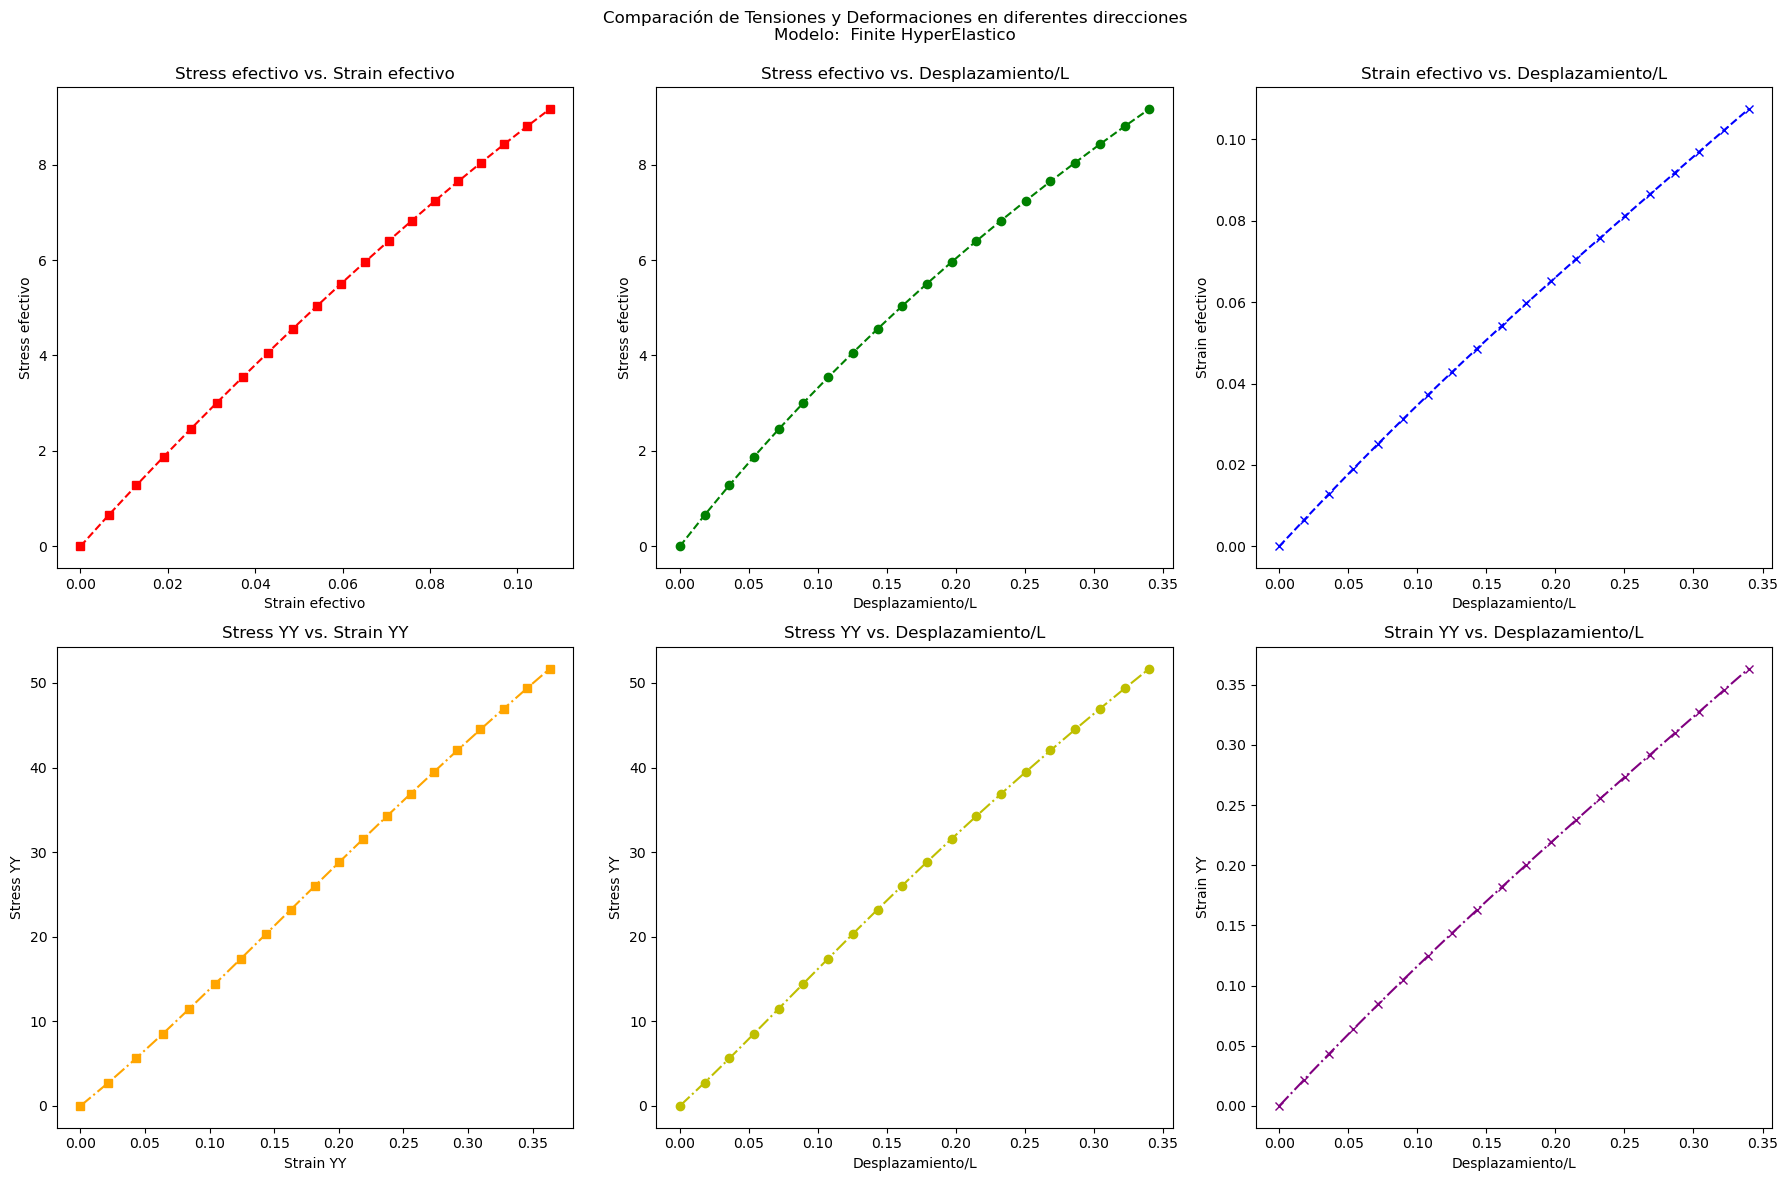

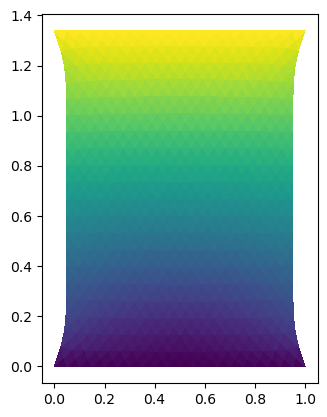

In [810]:

# Crear una lista para almacenar los resultados proyectados
resultados = []

# Definir una lista de valores de theta
L = 1
E = 100
nu = 0.40
Nmesh = 20
Aprox = "Finite"
Modelo = "Hyper"

# Definir la cantidad máxima de desplazamiento
desplazamiento_maximo = L * 0.34

# Resolver el problema elástico para diferentes valores de desplazamiento
for desplazamiento in np.linspace(0, desplazamiento_maximo, 20):
    # Resolver el problema elástico para obtener los desplazamientos
    u_solution = resolver_problema_elastico_T(E, nu, desplazamiento, Nmesh, L, Aprox, Modelo)
    
    # Crear el espacio de funciones para proyectar
    V = fe.FunctionSpace(u_solution.function_space().mesh(), "CG", 1)
    
    # Crear una función de prueba y un punto donde se proyectarán las funciones
    v = fe.TestFunction(V)
    point = fe.Point(0.5, 0.5)  # Punto en el dominio donde se proyectarán las funciones
    
    # Proyectar la función de esfuerzo en el punto
    stress_projection = fe.project(calcular_tension_efectiva(u_solution, E, nu, Aprox, Modelo), V)
    stress_at_point = stress_projection(point)
    
    # Proyectar la función de deformación en el punto
    strain_projection = fe.project(calcular_deformacion_efectiva(u_solution, E, nu, Aprox, Modelo), V)
    strain_at_point = strain_projection(point)
    
    # Proyectar el stress en YY en el punto
    stress_YY_projection = fe.project(calcular_tension_YY(u_solution, E, nu, Aprox, Modelo), V)
    stress_YY_at_point = stress_YY_projection(point)
    
    # Proyectar el strain en YY en el punto
    strain_YY_projection = fe.project(calcular_deformacion_YY(u_solution, E, nu, Aprox), V)
    strain_YY_at_point = strain_YY_projection(point)
    
    # Agregar los valores proyectados a la lista de resultados
    resultados.append((desplazamiento / L, strain_at_point, stress_at_point, strain_YY_at_point, stress_YY_at_point))

# Extraer los resultados de la lista de resultados
desplazamientos_L = [resultado[0] for resultado in resultados]
strains_efectivo = [resultado[1] for resultado in resultados]
stresses_efectivo = [resultado[2] for resultado in resultados]
strains_YY = [resultado[3] for resultado in resultados]
stresses_YY = [resultado[4] for resultado in resultados]

# Graficar los resultados en dos filas y tres columnas
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

# Graficar stress efectivo versus strain efectivo
ax[0, 0].plot(strains_efectivo, stresses_efectivo, marker='s', linestyle='--', color='r')
ax[0, 0].set_xlabel('Strain efectivo')
ax[0, 0].set_ylabel('Stress efectivo')
ax[0, 0].set_title('Stress efectivo vs. Strain efectivo')
#ax[0, 0].grid(True)

# Graficar stress efectivo versus desplazamiento/L
ax[0, 1].plot(desplazamientos_L, stresses_efectivo, marker='o', linestyle='--', color='g')
ax[0, 1].set_xlabel('Desplazamiento/L')
ax[0, 1].set_ylabel('Stress efectivo')
ax[0, 1].set_title('Stress efectivo vs. Desplazamiento/L')
#ax[0, 1].grid(True)

# Graficar strain efectivo versus desplazamiento/L
ax[0, 2].plot(desplazamientos_L, strains_efectivo, marker='x', linestyle='--', color='b')
ax[0, 2].set_xlabel('Desplazamiento/L')
ax[0, 2].set_ylabel('Strain efectivo')
ax[0, 2].set_title('Strain efectivo vs. Desplazamiento/L')
#ax[0, 2].grid(True)

# Graficar stress YY versus strain YY
ax[1, 0].plot(strains_YY, stresses_YY, marker='s', linestyle='-.', color='Orange')
ax[1, 0].set_xlabel('Strain YY')
ax[1, 0].set_ylabel('Stress YY')
ax[1, 0].set_title('Stress YY vs. Strain YY')
#ax[1, 0].grid(True)

# Graficar stress YY efectivo versus desplazamiento/L
ax[1, 1].plot(desplazamientos_L, stresses_YY, marker='o', linestyle='-.', color='y')
ax[1, 1].set_xlabel('Desplazamiento/L')
ax[1, 1].set_ylabel('Stress YY')
ax[1, 1].set_title('Stress YY vs. Desplazamiento/L')
#ax[1, 1].grid(True)

# Graficar strain YY versus desplazamiento/L
ax[1, 2].plot(desplazamientos_L, strains_YY,  marker='x', linestyle='-.', color='purple')
ax[1, 2].set_xlabel('Desplazamiento/L')
ax[1, 2].set_ylabel('Strain YY')
ax[1, 2].set_title('Strain YY vs. Desplazamiento/L')
#ax[1, 2].grid(True)

# Agregar título a toda la imagen
fig.suptitle('Comparación de Tensiones y Deformaciones en diferentes direcciones\n'+"Modelo:  "+Aprox+" "+Modelo+"Elastico"+"\n")

# Ajustar el espaciado entre subgráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

fe.plot(u_solution, mode="displacement")

                                                                                                                                                                                                                                                        No Jacobian form specified for nonlinear variational problem.
                                                                                                                                                                                                                                                        Differentiating residual form F to obtain Jacobian J = F'.
                                                                                                                                                                                                                                                        Solving nonlinear variational problem.
                                                                                                

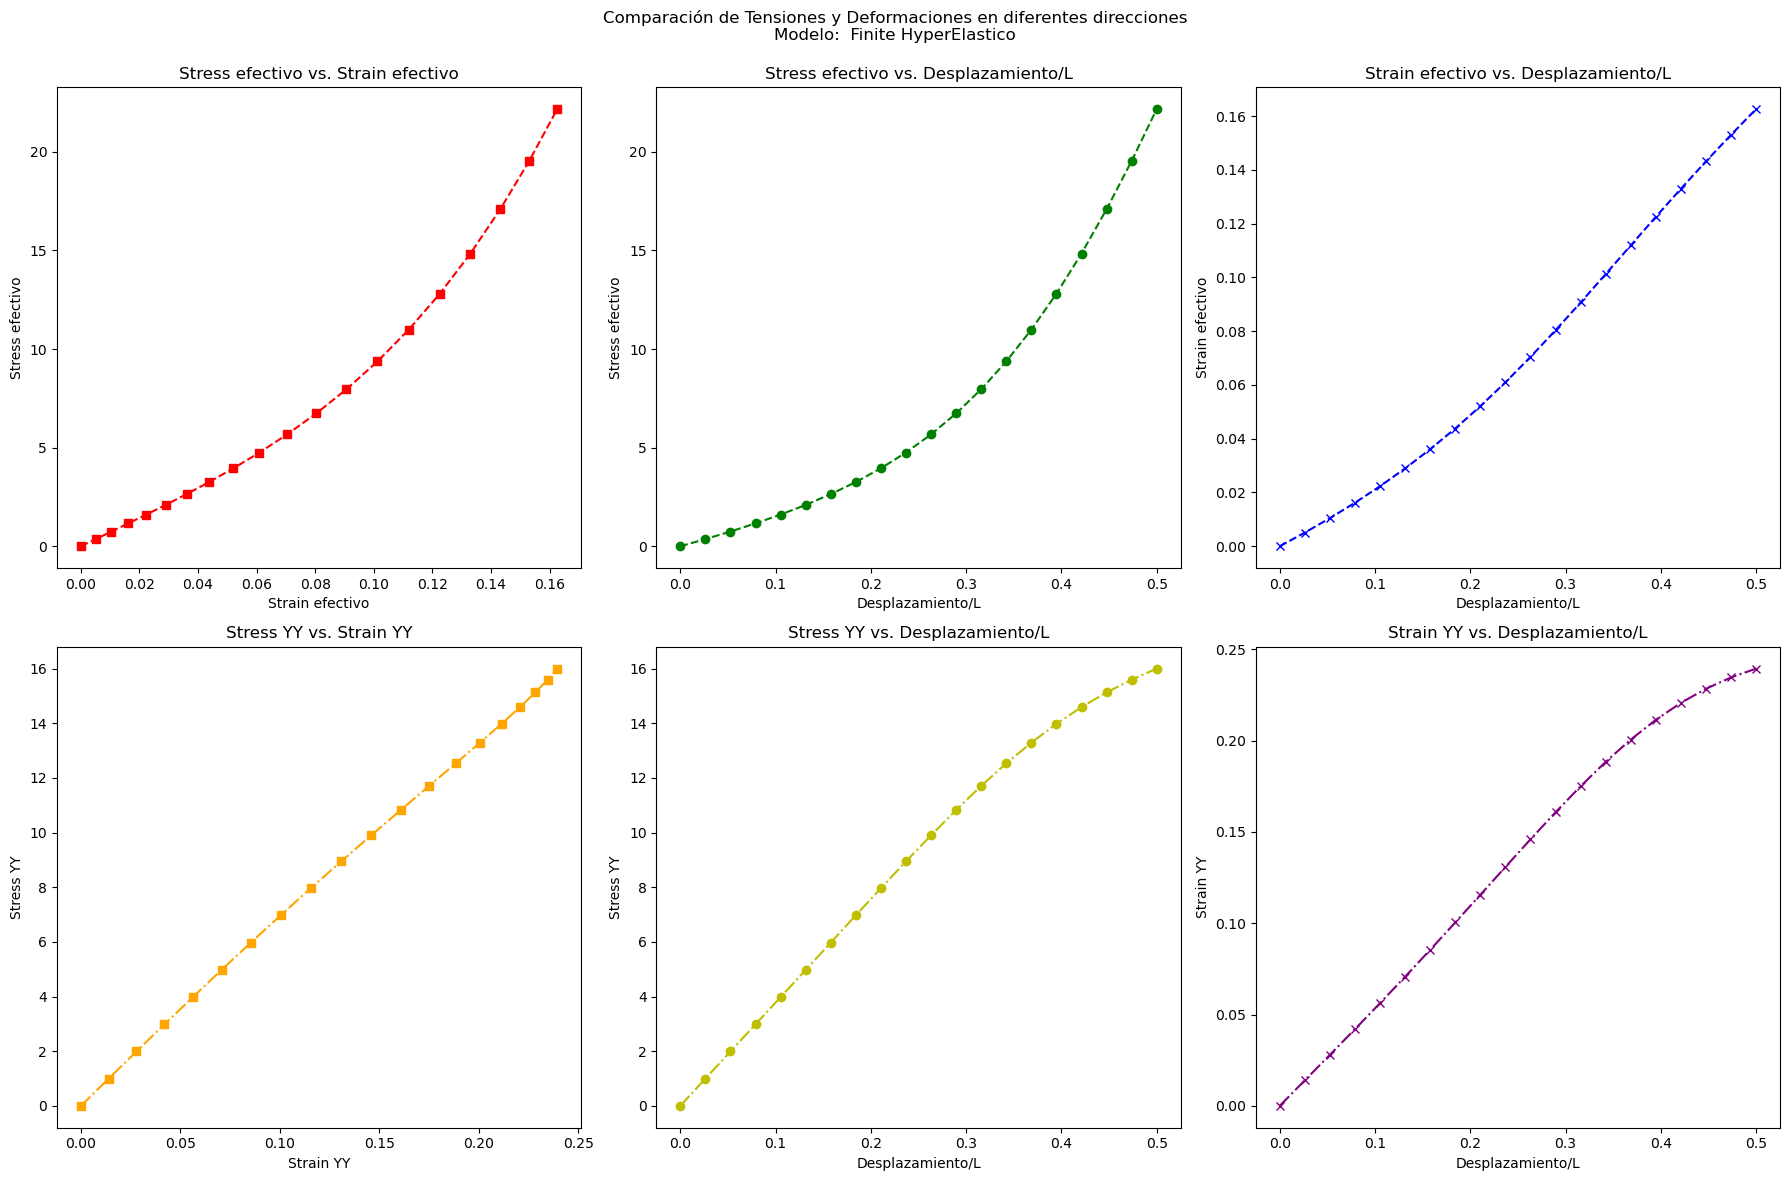

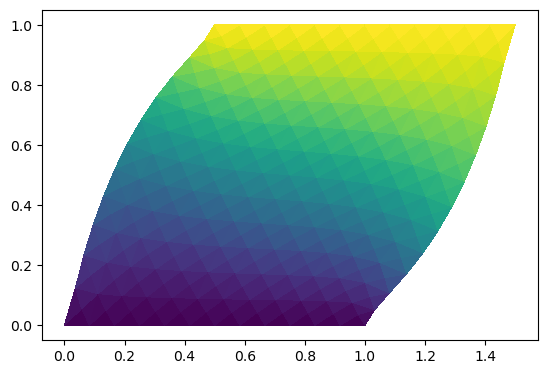

In [892]:
# Crear una lista para almacenar los resultados proyectados
resultados = []

# Definir una lista de valores de theta
L = 1
E = 100
nu = 0.40
Nmesh = 12
Aprox = "Finite"
Modelo = "Hyper"

# Definir la cantidad máxima de desplazamiento
desplazamiento_maximo = L * 0.5

# Resolver el problema elástico para diferentes valores de desplazamiento
for desplazamiento in np.linspace(0, desplazamiento_maximo, 20):
    # Resolver el problema elástico para obtener los desplazamientos
    u_solution = resolver_problema_elastico_C(E, nu, desplazamiento, Nmesh, L, Aprox, Modelo)
    
    # Crear el espacio de funciones para proyectar
    V = fe.FunctionSpace(u_solution.function_space().mesh(), "CG", 1)
    
    # Crear una función de prueba y un punto donde se proyectarán las funciones
    v = fe.TestFunction(V)
    point = fe.Point(0.5, 0.5)  # Punto en el dominio donde se proyectarán las funciones
    
    # Proyectar la función de esfuerzo en el punto
    stress_projection = fe.project(calcular_tension_efectiva(u_solution, E, nu, Aprox, Modelo), V)
    stress_at_point = stress_projection(point)
    
    # Proyectar la función de deformación en el punto
    strain_projection = fe.project(calcular_deformacion_efectiva(u_solution, E, nu, Aprox, Modelo), V)
    strain_at_point = strain_projection(point)
    
    # Proyectar el stress en YY en el punto
    stress_YY_projection = fe.project(calcular_tension_XY(u_solution, E, nu, Aprox, Modelo), V)
    stress_YY_at_point = stress_YY_projection(point)
    
    # Proyectar el strain en YY en el punto
    strain_YY_projection = fe.project(calcular_deformacion_XY(u_solution, E, nu, Aprox), V)
    strain_YY_at_point = strain_YY_projection(point)
    
    # Agregar los valores proyectados a la lista de resultados
    resultados.append((desplazamiento / L, strain_at_point, stress_at_point, strain_YY_at_point, stress_YY_at_point))

# Extraer los resultados de la lista de resultados
desplazamientos_L = [resultado[0] for resultado in resultados]
strains_efectivo = [resultado[1] for resultado in resultados]
stresses_efectivo = [resultado[2] for resultado in resultados]
strains_YY = [resultado[3] for resultado in resultados]
stresses_YY = [resultado[4] for resultado in resultados]

# Graficar los resultados en dos filas y tres columnas
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

# Graficar stress efectivo versus strain efectivo
ax[0, 0].plot(strains_efectivo, stresses_efectivo, marker='s', linestyle='--', color='r')
ax[0, 0].set_xlabel('Strain efectivo')
ax[0, 0].set_ylabel('Stress efectivo')
ax[0, 0].set_title('Stress efectivo vs. Strain efectivo')
#ax[0, 0].grid(True)

# Graficar stress efectivo versus desplazamiento/L
ax[0, 1].plot(desplazamientos_L, stresses_efectivo, marker='o', linestyle='--', color='g')
ax[0, 1].set_xlabel('Desplazamiento/L')
ax[0, 1].set_ylabel('Stress efectivo')
ax[0, 1].set_title('Stress efectivo vs. Desplazamiento/L')
#ax[0, 1].grid(True)

# Graficar strain efectivo versus desplazamiento/L
ax[0, 2].plot(desplazamientos_L, strains_efectivo, marker='x', linestyle='--', color='b')
ax[0, 2].set_xlabel('Desplazamiento/L')
ax[0, 2].set_ylabel('Strain efectivo')
ax[0, 2].set_title('Strain efectivo vs. Desplazamiento/L')
#ax[0, 2].grid(True)

# Graficar stress YY versus strain YY
ax[1, 0].plot(strains_YY, stresses_YY, marker='s', linestyle='-.', color='Orange')
ax[1, 0].set_xlabel('Strain YY')
ax[1, 0].set_ylabel('Stress YY')
ax[1, 0].set_title('Stress YY vs. Strain YY')
#ax[1, 0].grid(True)

# Graficar stress YY efectivo versus desplazamiento/L
ax[1, 1].plot(desplazamientos_L, stresses_YY, marker='o', linestyle='-.', color='y')
ax[1, 1].set_xlabel('Desplazamiento/L')
ax[1, 1].set_ylabel('Stress YY')
ax[1, 1].set_title('Stress YY vs. Desplazamiento/L')
#ax[1, 1].grid(True)

# Graficar strain YY versus desplazamiento/L
ax[1, 2].plot(desplazamientos_L, strains_YY,  marker='x', linestyle='-.', color='purple')
ax[1, 2].set_xlabel('Desplazamiento/L')
ax[1, 2].set_ylabel('Strain YY')
ax[1, 2].set_title('Strain YY vs. Desplazamiento/L')
#ax[1, 2].grid(True)

# Agregar título a toda la imagen
fig.suptitle('Comparación de Tensiones y Deformaciones en diferentes direcciones\n'+"Modelo:  "+Aprox+" "+Modelo+"Elastico"+"\n")

# Ajustar el espaciado entre subgráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

fe.plot(u_solution, mode="displacement")